# Club calc is not working

In [679]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import warnings
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from xgboost import XGBRegressor

In [592]:
path = '../Data'

csv_files = glob.glob(path + "/*.csv")
to_remove = ['../Data/game_lineups.csv',
             '../Data/game_events.csv',
             '../Data/games.csv',
             '../Data/club_games.csv'
            ]
csv_files = [x for x in csv_files if x not in to_remove]

# Create an empty dictionary to store the DataFrames
dataframes = {}

for file in csv_files:
  # Get the base name of the file
  base_name = os.path.basename(file)
  
  # Remove the .csv extension to get the clean name
  # and add '_df' to match your requested format
  df_name = f"{os.path.splitext(base_name)[0]}_df"
  
  # Read the csv and add it to the dictionary
  dataframes[df_name] = pd.read_csv(file)

print("Available DataFrames:", list(dataframes.keys()))

Available DataFrames: ['appearances_df', 'clubs_df', 'club_games_df', 'competitions_df', 'games_df', 'game_events_df', 'game_lineups_df', 'players_df', 'player_valuations_df', 'transfers_df']


In [593]:
# Unpack the dictionary into separate global variables
for name, df in dataframes.items():
  globals()[name] = df

In [594]:
competitions_df.head()

,competition_id,competition_code,name,sub_type,type,country_id,country_name,domestic_league_code,confederation,url,is_major_national_league
0,CIT,italy-cup,italy-cup,domestic_cup,domestic_cup,75,Italy,IT1,europa,https://www.transfermarkt.co.uk/italy-cup/star...,False
1,NLSC,johan-cruijff-schaal,johan-cruijff-schaal,domestic_super_cup,other,122,Netherlands,NL1,europa,https://www.transfermarkt.co.uk/johan-cruijff-...,False
2,GRP,kypello-elladas,kypello-elladas,domestic_cup,domestic_cup,56,Greece,GR1,europa,https://www.transfermarkt.co.uk/kypello-ellada...,False
3,POSU,supertaca-candido-de-oliveira,supertaca-candido-de-oliveira,domestic_super_cup,other,136,Portugal,PO1,europa,https://www.transfermarkt.co.uk/supertaca-cand...,False
4,RUSS,russian-super-cup,russian-super-cup,domestic_super_cup,other,141,Russia,RU1,europa,https://www.transfermarkt.co.uk/russian-super-...,False


In [595]:
for name, df_object in dataframes.items():
    print(f"--- Analyzing: {name} ---")
    print("Head:")
    print(df_object.head())
    print("\nInfo:")
    df_object.info()
    print("\nDescribe:")
    print(df_object.describe())
    print("\n" + "="*50 + "\n")

--- Analyzing: appearances_df ---
Head:
    appearance_id  game_id  player_id  player_club_id  player_current_club_id  \
0   2231978_38004  2231978      38004             853                     235   
1   2233748_79232  2233748      79232            8841                    2698   
2   2234413_42792  2234413      42792            6251                     465   
3   2234418_73333  2234418      73333            1274                    6646   
4  2234421_122011  2234421     122011             195                    3008   

         date       player_name competition_id  yellow_cards  red_cards  \
0  2012-07-03  Aurélien Joachim            CLQ             0          0   
1  2012-07-05    Ruslan Abyshov            ELQ             0          0   
2  2012-07-05       Sander Puri            ELQ             0          0   
3  2012-07-05   Vegar Hedenstad            ELQ             0          0   
4  2012-07-05  Markus Henriksen            ELQ             0          0   

   goals  assists  min

In [596]:
#Dropping unsued columns
players_df.drop(columns = ['first_name', 'last_name','player_code', 'image_url', 'url'], inplace = True)
competitions_df.drop(columns = ['competition_code','sub_type', 'url'], inplace=True)
clubs_df.drop(columns = ['filename', 'url'], inplace=True)

In [597]:
for name, df_object in dataframes.items():
    print(f"--- Null Rows for {name} ---")
    null_rows = df_object[df_object.isnull().any(axis=1)]
    print(null_rows)

--- Null Rows for appearances_df ---
         appearance_id  game_id  player_id  player_club_id  \
799042  3084062_380365  3084062     380365           16486   
799117  3084059_411294  3084059     411294            3302   
799150  3084057_255495  3084057     255495           11596   
799165  3102749_380365  3102749     380365           16486   
816192  3106648_255495  3106648     255495           11596   
840806  3118604_411294  3118604     411294            3302   

        player_current_club_id        date player_name competition_id  \
799042                      -1  2018-09-05         NaN            CDR   
799117                      -1  2018-09-11         NaN            CDR   
799150                      -1  2018-09-12         NaN            CDR   
799165                      -1  2018-09-12         NaN            CDR   
816192                      -1  2018-10-17         NaN            CDR   
840806                      -1  2018-12-05         NaN            CDR   

        yellow_c

### Notes: 
Null rows for competitions are international (rightfully N/A)

Six appearances rows for copa del rey cup do not have player names, but do have IDs. Can drop

For transfers_df, many null transfer fee and market_value_in_eur. May drop or impute missing values later.

For players_df, many null values. About half of agent_names are missing, contract_expiration_date also has high NaN %. Will need to examine separately. 

For clubs_df, some missing values including a completely NaN total_market_value and coach_name value. Will also need to look at separately.

In [598]:
appearances_df.dropna(inplace=True)

In [599]:
players_df.head()

,player_id,name,last_season,current_club_id,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
0,10,Miroslav Klose,2015,398,Poland,Opole,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.0,NaN,ASBW Sport Marketing,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0
1,26,Roman Weidenfeller,2017,16,Germany,Diez,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.0,NaN,Neubauer 13 GmbH,L1,Borussia Dortmund,750000.0,8000000.0
2,65,Dimitar Berbatov,2015,1091,Bulgaria,Blagoevgrad,Bulgaria,1981-01-30 00:00:00,Centre-Forward,Attack,NaN,NaN,NaN,CSKA-AS-23 Ltd.,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,34500000.0
3,77,Lúcio,2012,506,Brazil,Brasília,Brazil,1978-05-08 00:00:00,Centre-Back,Defender,NaN,NaN,NaN,NaN,IT1,Juventus Football Club,200000.0,24500000.0
4,80,Tom Starke,2017,27,East Germany (GDR),Freital,Germany,1981-03-18 00:00:00,Goalkeeper,Goalkeeper,right,194.0,NaN,IFM,L1,FC Bayern München,100000.0,3000000.0


In [600]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32601 entries, 0 to 32600
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   player_id                             32601 non-null  int64  
 1   name                                  32601 non-null  object 
 2   last_season                           32601 non-null  int64  
 3   current_club_id                       32601 non-null  int64  
 4   country_of_birth                      29802 non-null  object 
 5   city_of_birth                         30146 non-null  object 
 6   country_of_citizenship                32218 non-null  object 
 7   date_of_birth                         32554 non-null  object 
 8   sub_position                          32421 non-null  object 
 9   position                              32601 non-null  object 
 10  foot                                  30065 non-null  object 
 11  height_in_cm   

In [601]:
players_df.isnull().sum()

player_id                                   0
name                                        0
last_season                                 0
current_club_id                             0
country_of_birth                         2799
city_of_birth                            2455
country_of_citizenship                    383
date_of_birth                              47
sub_position                              180
position                                    0
foot                                     2536
height_in_cm                             2256
contract_expiration_date                12091
agent_name                              16019
current_club_domestic_competition_id        0
current_club_name                           0
market_value_in_eur                      1523
highest_market_value_in_eur              1523
dtype: int64

In [602]:
# Create a boolean mask where the condition is True
mask = players_df['country_of_birth'] == players_df['country_of_citizenship']

# Sum the True values (since True=1, False=0) to get the count
count = mask.sum()

print(f"Number of rows where birth country equals citizenship: {count}")

Number of rows where birth country equals citizenship: 24677


In [603]:
players_df['country_of_birth'] = players_df['country_of_birth'].fillna(players_df['country_of_citizenship'])

In [604]:
players_df.isnull().sum()

player_id                                   0
name                                        0
last_season                                 0
current_club_id                             0
country_of_birth                          382
city_of_birth                            2455
country_of_citizenship                    383
date_of_birth                              47
sub_position                              180
position                                    0
foot                                     2536
height_in_cm                             2256
contract_expiration_date                12091
agent_name                              16019
current_club_domestic_competition_id        0
current_club_name                           0
market_value_in_eur                      1523
highest_market_value_in_eur              1523
dtype: int64

In [605]:
players_df = players_df.dropna(subset=['country_of_birth', 'country_of_citizenship'])

In [606]:
players_df['country_of_birth'][players_df['city_of_birth'].isna()].value_counts()

country_of_birth
Denmark        507
Belgium        369
Greece         183
Ukraine        141
Netherlands    141
              ... 
Angola           1
Luxembourg       1
Japan            1
Chile            1
Moldova          1
Name: count, Length: 87, dtype: int64

city_of_birth is probably too granular than what we need, and does not seem to be randomly missing. Dropping column

In [607]:
players_df = players_df.drop(columns=['city_of_birth'])

In [608]:
players_df['position'][players_df['sub_position'].isna()].value_counts()

position
Missing    180
Name: count, dtype: int64

In [609]:
players_df = players_df.dropna(subset=['position', 'sub_position'])

In [610]:
players_df = players_df.dropna(subset=['date_of_birth'])

In [611]:
players_df['sub_position'][players_df['foot'].isna()].value_counts()

sub_position
Goalkeeper            529
Centre-Back           388
Centre-Forward        381
Central Midfield      298
Defensive Midfield    158
Attacking Midfield    156
Left Winger           137
Right-Back             98
Right Winger           95
Left-Back              82
Left Midfield          27
Right Midfield         27
Second Striker         11
Name: count, dtype: int64

In [612]:
players_df['foot'].value_counts()

foot
right    20835
left      7412
both      1363
Name: count, dtype: int64

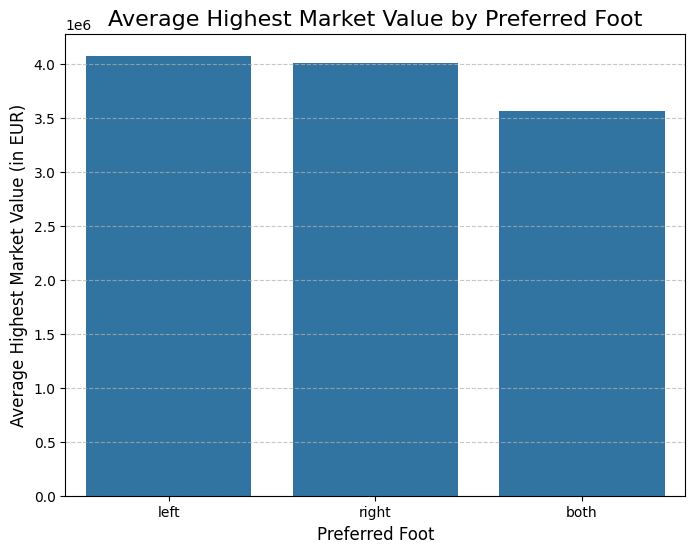

In [613]:
# Group by 'foot' and calculate the mean of the highest market value
avg_value_by_foot = players_df.groupby('foot')['highest_market_value_in_eur'].mean().reset_index()

# Sort the values for a cleaner plot
avg_value_by_foot = avg_value_by_foot.sort_values('highest_market_value_in_eur', ascending=False)


# --- Plotting ---
plt.figure(figsize=(8, 6))
sns.barplot(x='foot', y='highest_market_value_in_eur', data=avg_value_by_foot)

plt.title('Average Highest Market Value by Preferred Foot', fontsize=16)
plt.xlabel('Preferred Foot', fontsize=12)
plt.ylabel('Average Highest Market Value (in EUR)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [614]:
avg_value_by_foot

,foot,highest_market_value_in_eur
1,left,4.072432e+06
2,right,4.003072e+06
0,both,3.564317e+06


In [615]:
#too many values to drop, going to impute 'unknown' cat
players_df['foot'] = players_df['foot'].fillna('Unknown')

In [616]:
#height_in_cm can be replaced with averages. 
#Since players' positions can be a good indicator of height, we'll use average by sub_position
imputed_height = players_df.groupby('sub_position')['height_in_cm'].transform('mean')

# Fill the NaN values in the original column using this new series
players_df['height_in_cm'] = players_df['height_in_cm'].fillna(imputed_height)

In [617]:
# Get today's date
today = pd.to_datetime('today')

# Ensure the contract expiration date column is in datetime format
players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'])


# --- 1. Feature Engineering: Calculate Contract Days Remaining ---
# Create a new feature for the number of days left on the contract from today
players_df['contract_days_remaining'] = (players_df['contract_expiration_date'] - today).dt.days


# --- 2. Handle the Missing Values ---

# Step A: Create a binary flag for missing contract data
players_df['contract_info_missing'] = players_df['contract_days_remaining'].isnull().astype(int)


# Step B: Impute the missing values in the 'contract_days_remaining' column
# Filling with the median is a robust choice
median_contract_days = players_df['contract_days_remaining'].median()
players_df['contract_days_remaining'] = players_df['contract_days_remaining'].fillna(median_contract_days)


# Drop the original, less useful date column.
players_df = players_df.drop(columns=['contract_expiration_date'])

players_df.head()

,player_id,name,last_season,current_club_id,country_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur,contract_days_remaining,contract_info_missing
0,10,Miroslav Klose,2015,398,Poland,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.000000,ASBW Sport Marketing,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0,-26.0,1
1,26,Roman Weidenfeller,2017,16,Germany,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.000000,Neubauer 13 GmbH,L1,Borussia Dortmund,750000.0,8000000.0,-26.0,1
2,65,Dimitar Berbatov,2015,1091,Bulgaria,Bulgaria,1981-01-30 00:00:00,Centre-Forward,Attack,Unknown,184.035063,CSKA-AS-23 Ltd.,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,34500000.0,-26.0,1
3,77,Lúcio,2012,506,Brazil,Brazil,1978-05-08 00:00:00,Centre-Back,Defender,Unknown,187.358271,NaN,IT1,Juventus Football Club,200000.0,24500000.0,-26.0,1
4,80,Tom Starke,2017,27,East Germany (GDR),Germany,1981-03-18 00:00:00,Goalkeeper,Goalkeeper,right,194.000000,IFM,L1,FC Bayern München,100000.0,3000000.0,-26.0,1


In [618]:
players_df['agent_name'] = players_df['agent_name'].fillna('Unknown')

In [619]:
players_df.isnull().sum()

player_id                                  0
name                                       0
last_season                                0
current_club_id                            0
country_of_birth                           0
country_of_citizenship                     0
date_of_birth                              0
sub_position                               0
position                                   0
foot                                       0
height_in_cm                               0
agent_name                                 0
current_club_domestic_competition_id       0
current_club_name                          0
market_value_in_eur                     1413
highest_market_value_in_eur             1413
contract_days_remaining                    0
contract_info_missing                      0
dtype: int64

I'm going to drop highest_market_value_in_eur. The goal is to effectively model player values, and this will lead to leakage. 

In [620]:
players_df = players_df.drop(columns=['highest_market_value_in_eur'])

In [621]:
players_df = players_df.dropna(subset=['market_value_in_eur'])

In [622]:
players_df.head()

,player_id,name,last_season,current_club_id,country_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,current_club_name,market_value_in_eur,contract_days_remaining,contract_info_missing
0,10,Miroslav Klose,2015,398,Poland,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.000000,ASBW Sport Marketing,IT1,Società Sportiva Lazio S.p.A.,1000000.0,-26.0,1
1,26,Roman Weidenfeller,2017,16,Germany,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.000000,Neubauer 13 GmbH,L1,Borussia Dortmund,750000.0,-26.0,1
2,65,Dimitar Berbatov,2015,1091,Bulgaria,Bulgaria,1981-01-30 00:00:00,Centre-Forward,Attack,Unknown,184.035063,CSKA-AS-23 Ltd.,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,-26.0,1
3,77,Lúcio,2012,506,Brazil,Brazil,1978-05-08 00:00:00,Centre-Back,Defender,Unknown,187.358271,Unknown,IT1,Juventus Football Club,200000.0,-26.0,1
4,80,Tom Starke,2017,27,East Germany (GDR),Germany,1981-03-18 00:00:00,Goalkeeper,Goalkeeper,right,194.000000,IFM,L1,FC Bayern München,100000.0,-26.0,1


We can grab some new features from other dfs

In [623]:
appearances_df.head()

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90
2,2234413_42792,2234413,42792,6251,465,2012-07-05,Sander Puri,ELQ,0,0,0,0,45
3,2234418_73333,2234418,73333,1274,6646,2012-07-05,Vegar Hedenstad,ELQ,0,0,0,0,90
4,2234421_122011,2234421,122011,195,3008,2012-07-05,Markus Henriksen,ELQ,0,0,0,1,90


In [624]:
#Get totals for stats from appearances_df
sum_cols = ['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played']

player_stats = appearances_df.groupby('player_id')[sum_cols].sum()
players_df = pd.merge(players_df, player_stats, on='player_id', how='left')
players_df[sum_cols] = players_df[sum_cols].fillna(0)

In [625]:
players_df.sort_values('goals', ascending=False).head()

,player_id,name,last_season,current_club_id,country_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,current_club_name,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played
3223,38253,Robert Lewandowski,2024,131,Poland,Poland,1988-08-21 00:00:00,Centre-Forward,Attack,right,185.0,Gol International,ES1,Futbol Club Barcelona,15000000.0,339.0,0,59.0,1.0,507.0,118.0,51228.0
2325,28003,Lionel Messi,2022,583,Argentina,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,Unknown,FR1,Paris Saint-Germain Football Club,35000000.0,-26.0,1,49.0,1.0,451.0,224.0,44380.0
747,8198,Cristiano Ronaldo,2022,985,Portugal,Portugal,1985-02-05 00:00:00,Centre-Forward,Attack,right,187.0,Gestifute,GB1,Manchester United Football Club,15000000.0,-26.0,0,64.0,4.0,432.0,114.0,41150.0
9295,132098,Harry Kane,2024,27,England,England,1993-07-28 00:00:00,Centre-Forward,Attack,right,188.0,CK66,L1,FC Bayern München,90000000.0,704.0,0,52.0,0.0,346.0,85.0,39942.0
5140,58864,Pierre-Emerick Aubameyang,2023,244,France,Gabon,1989-06-18 00:00:00,Centre-Forward,Attack,right,187.0,Unknown,FR1,Olympique de Marseille,5000000.0,339.0,0,36.0,1.0,294.0,80.0,38613.0


In [626]:
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])

In [627]:
players_df['age_in_days'] = (today - players_df['date_of_birth']).dt.days
players_df = players_df.drop(columns=['date_of_birth'])

In [628]:
players_df.columns

Index(['player_id', 'name', 'last_season', 'current_club_id',
       'country_of_birth', 'country_of_citizenship', 'sub_position',
       'position', 'foot', 'height_in_cm', 'agent_name',
       'current_club_domestic_competition_id', 'current_club_name',
       'market_value_in_eur', 'contract_days_remaining',
       'contract_info_missing', 'yellow_cards', 'red_cards', 'goals',
       'assists', 'minutes_played', 'age_in_days'],
      dtype='object')

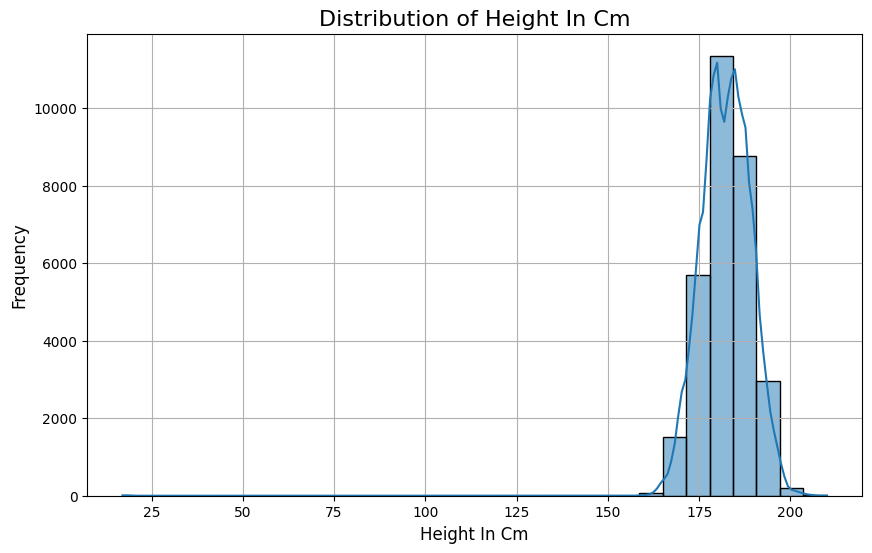

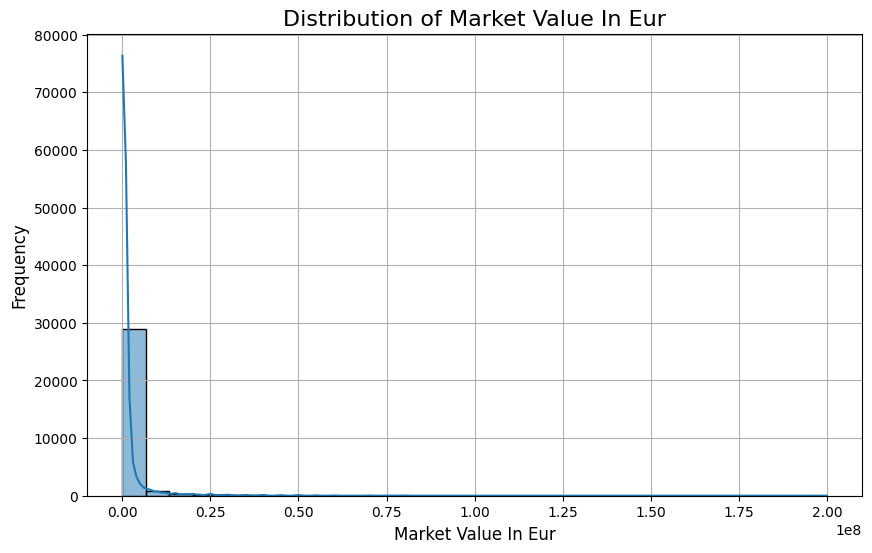

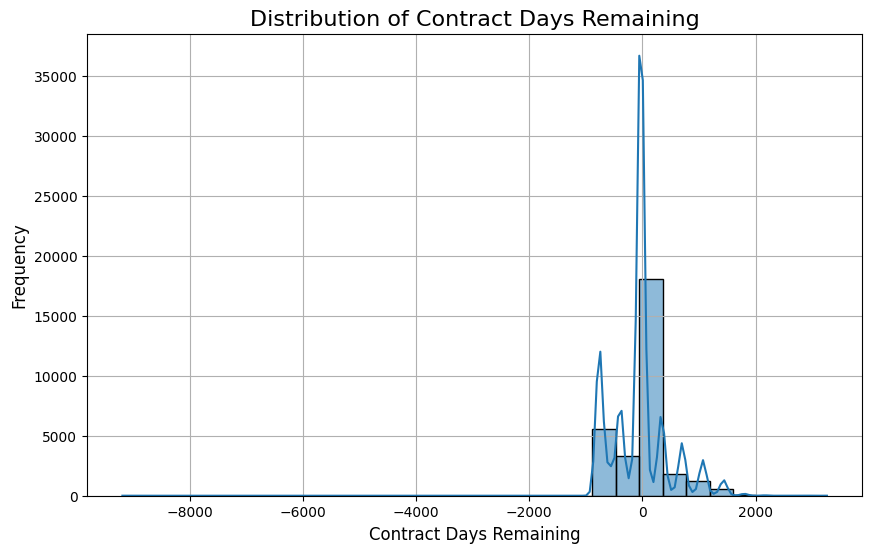

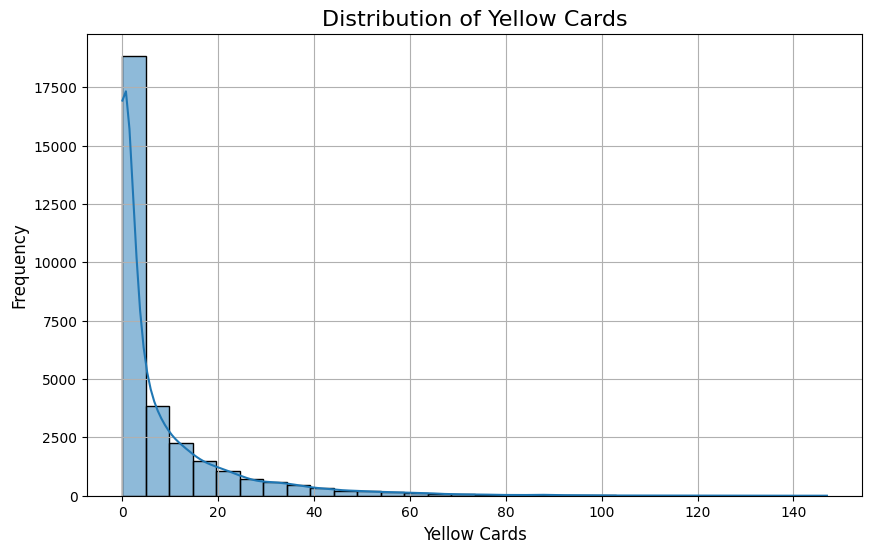

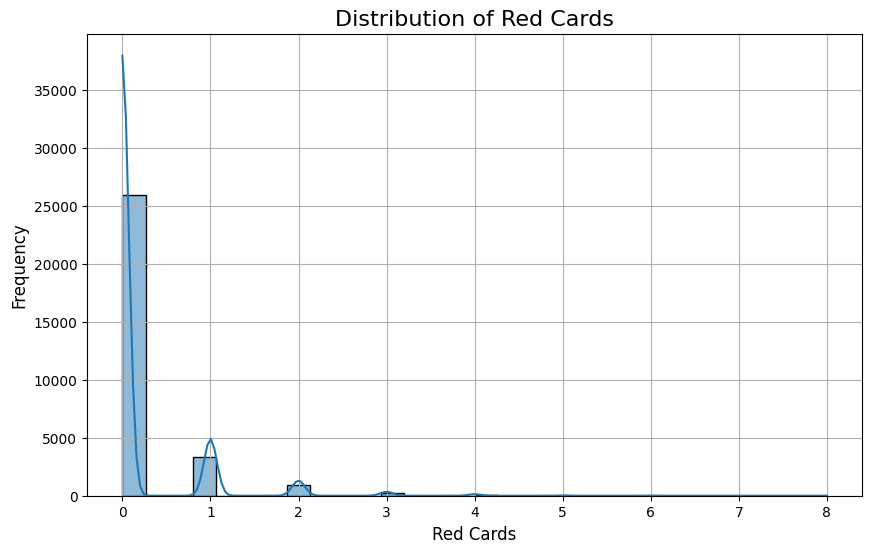

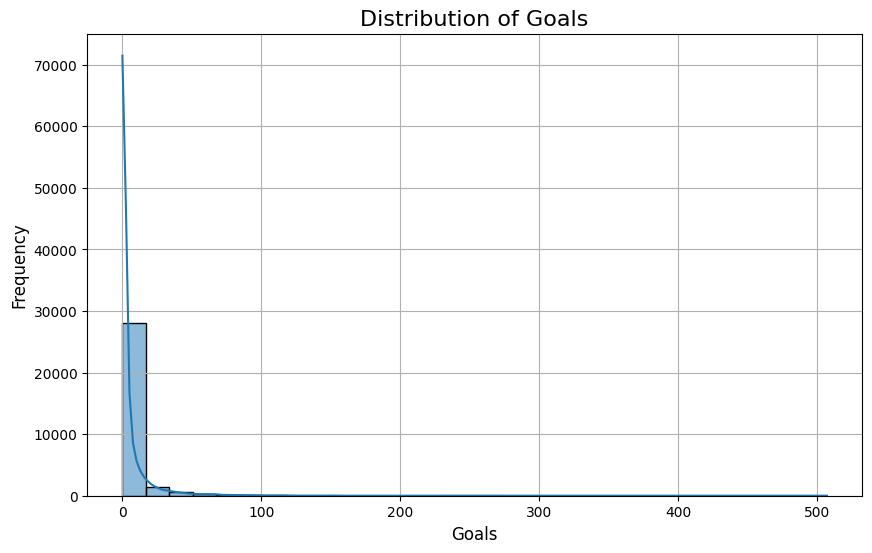

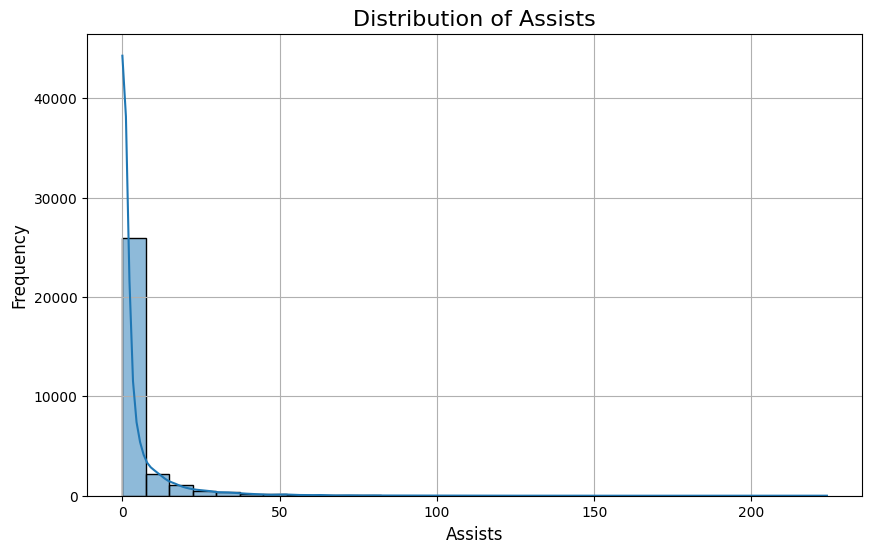

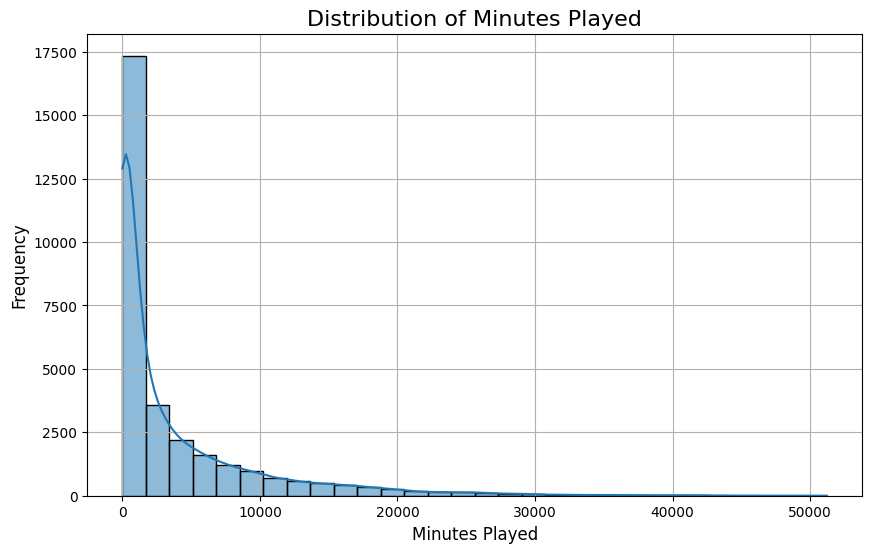

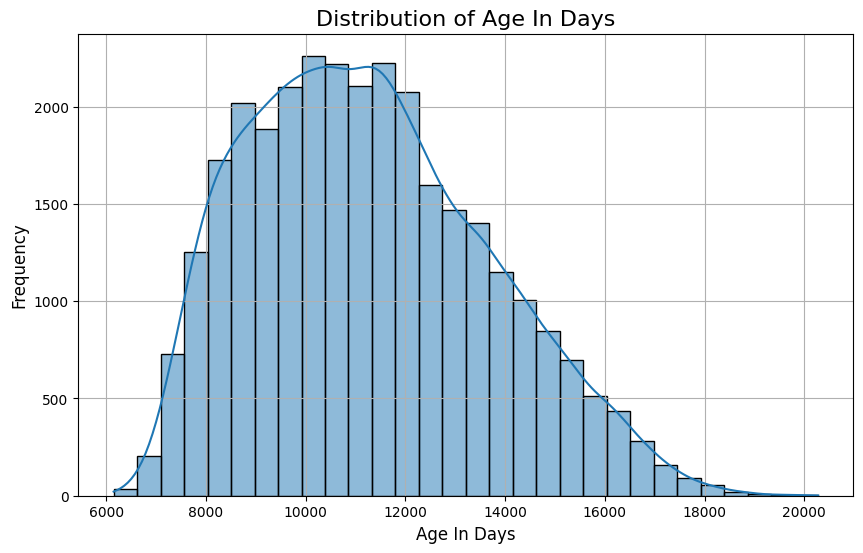

In [629]:
num_cols = [
    'height_in_cm', 'market_value_in_eur', 'contract_days_remaining', 
    'yellow_cards', 'red_cards', 'goals','assists', 'minutes_played', 
    'age_in_days'
]

cat_cols = [
    'current_club_id','country_of_birth', 'country_of_citizenship',
    'sub_position', 'position', 'foot', 'agent_name',
    'current_club_domestic_competition_id', 'current_club_name', 
    'contract_info_missing'
]

for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(players_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col.replace("_", " ").title()}', fontsize=16)
    plt.xlabel(col.replace("_", " ").title(), fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    plt.show()

C:\Users\phill\anaconda3\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


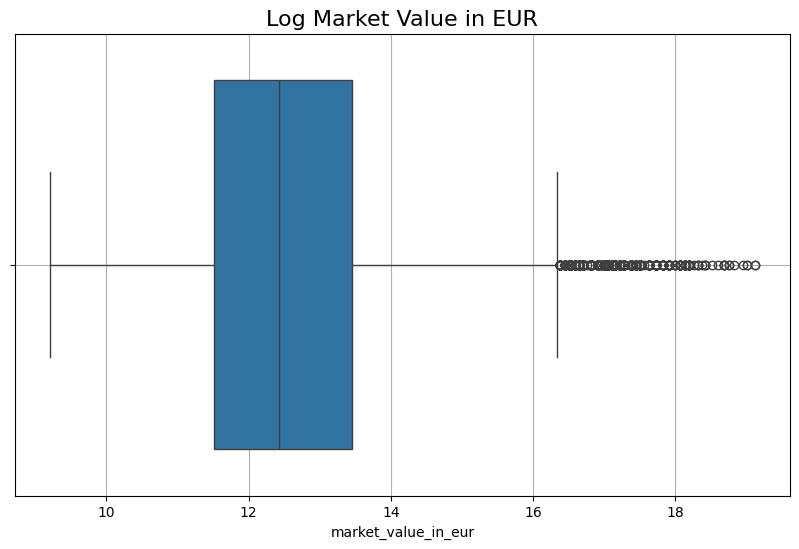

In [630]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=np.log1p(players_df['market_value_in_eur'])) 
plt.title('Log Market Value in EUR', fontsize=16)
plt.grid(True)
plt.show()

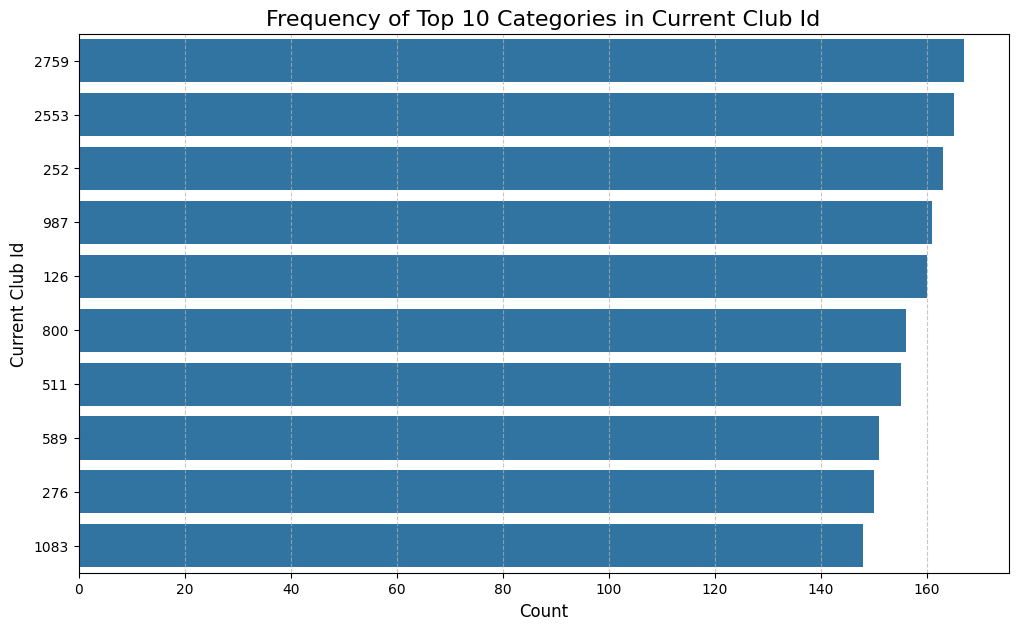

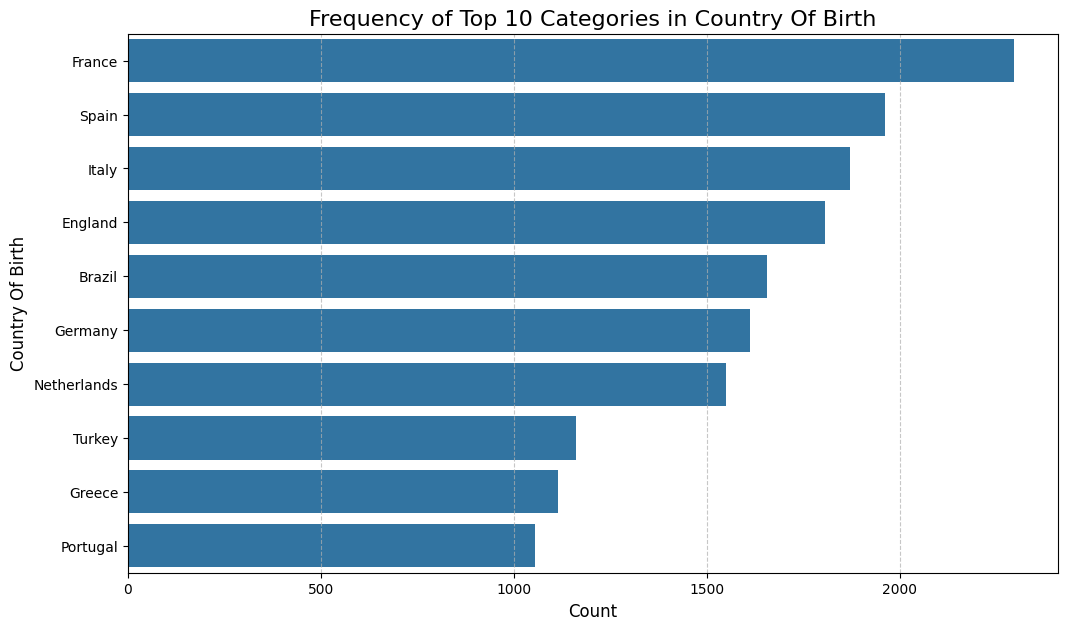

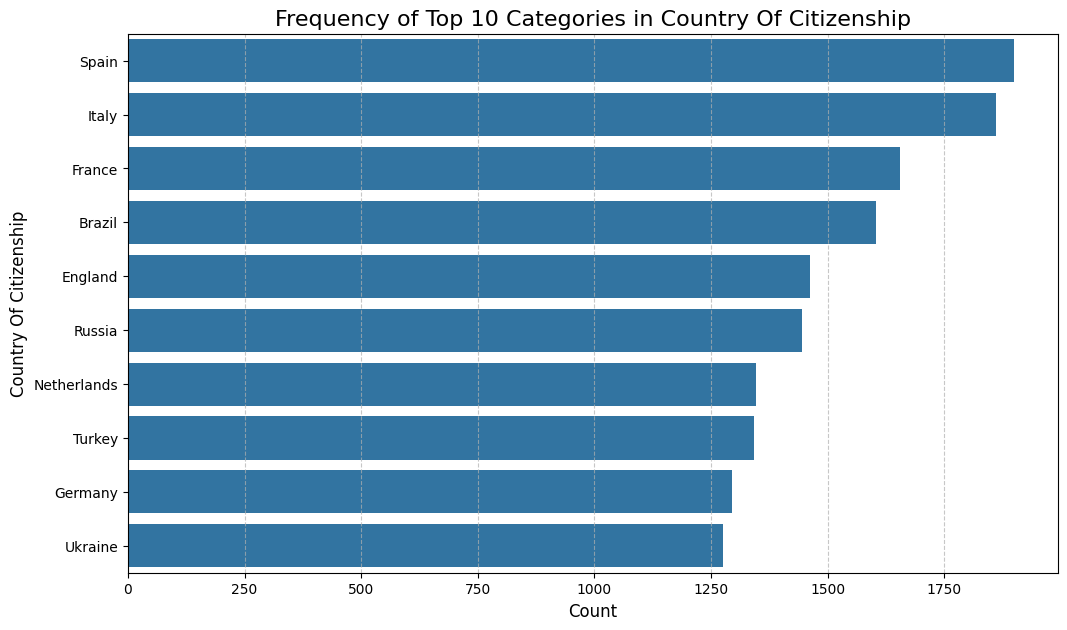

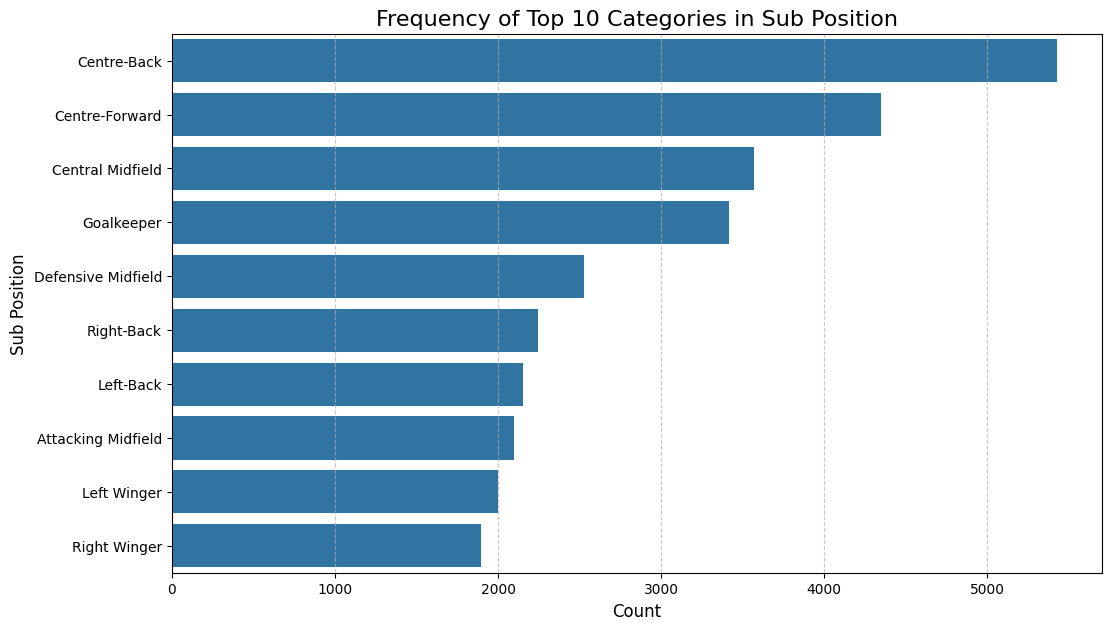

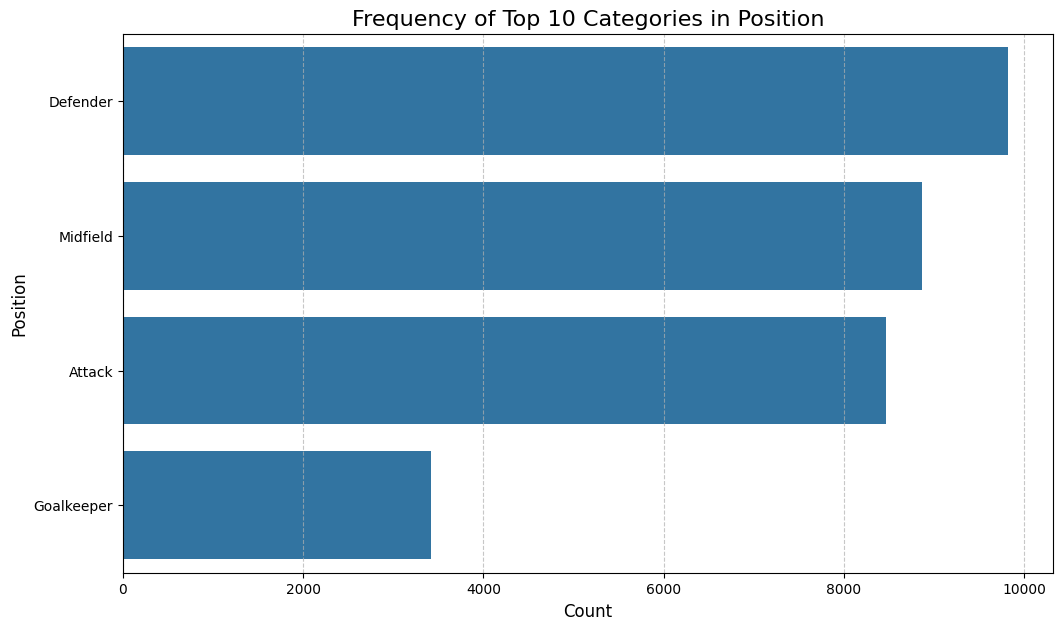

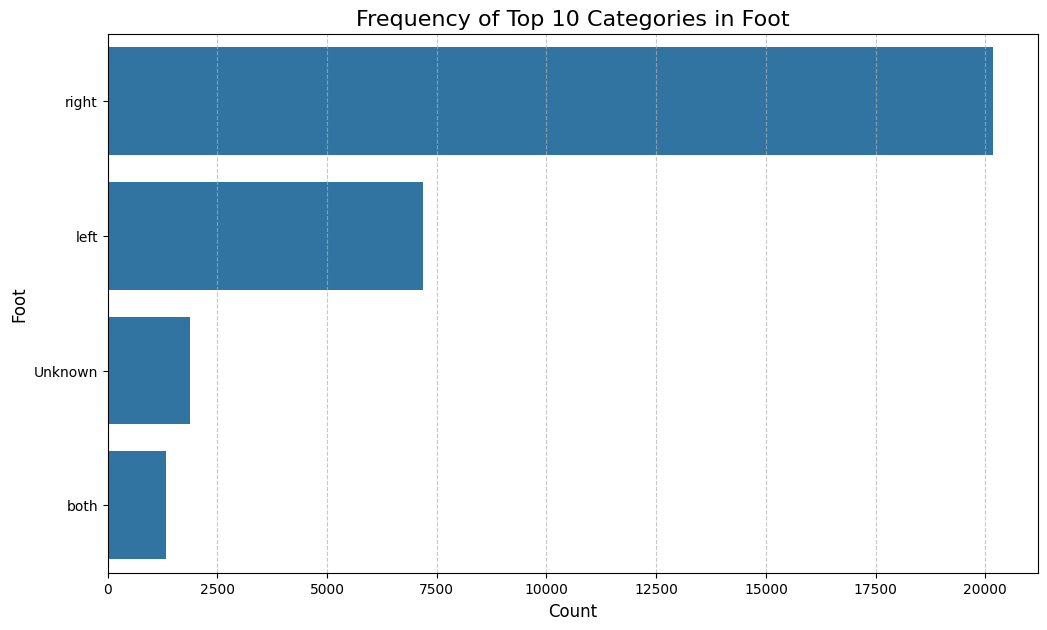

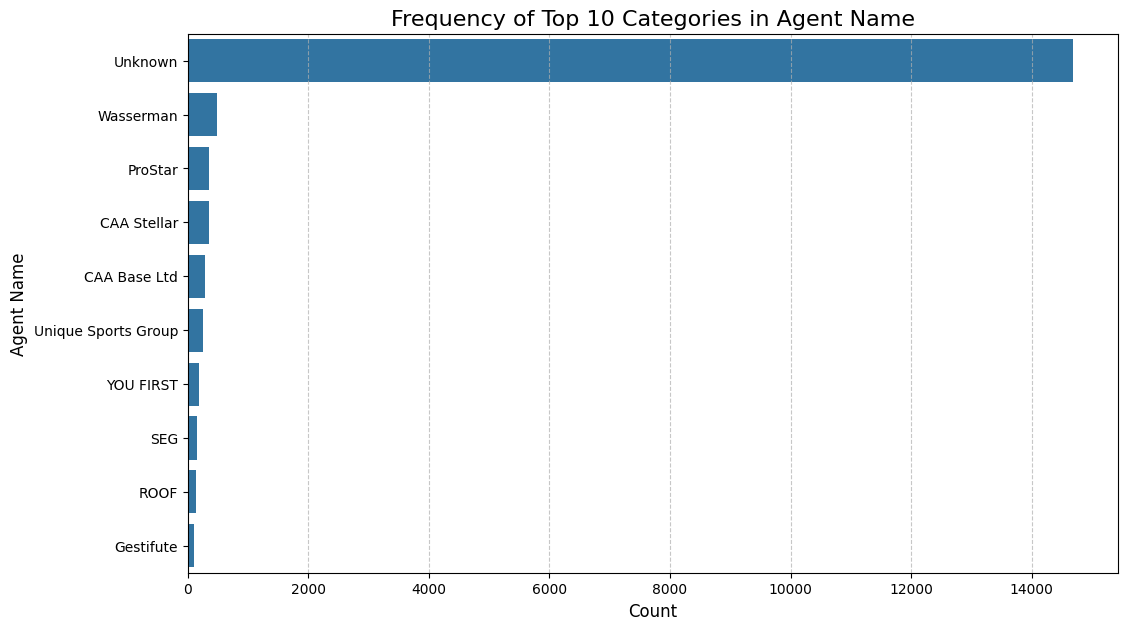

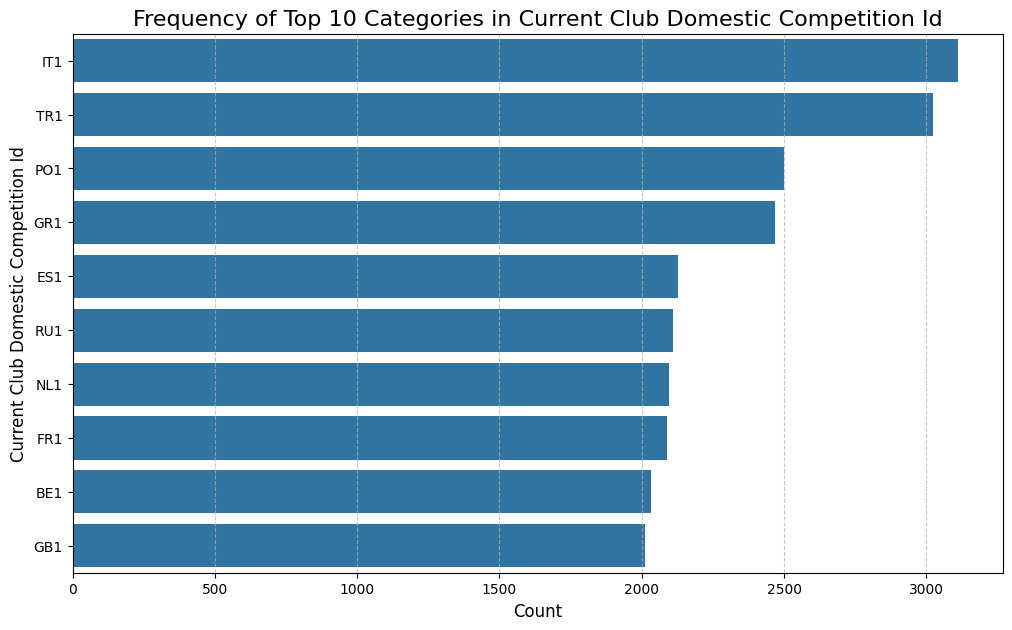

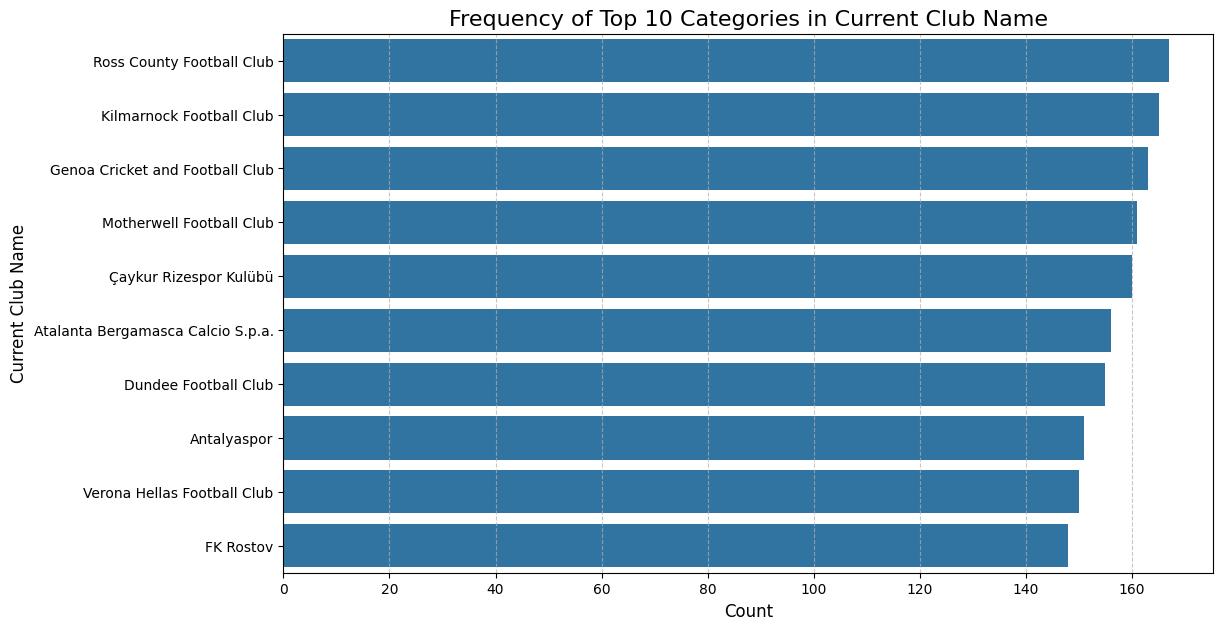

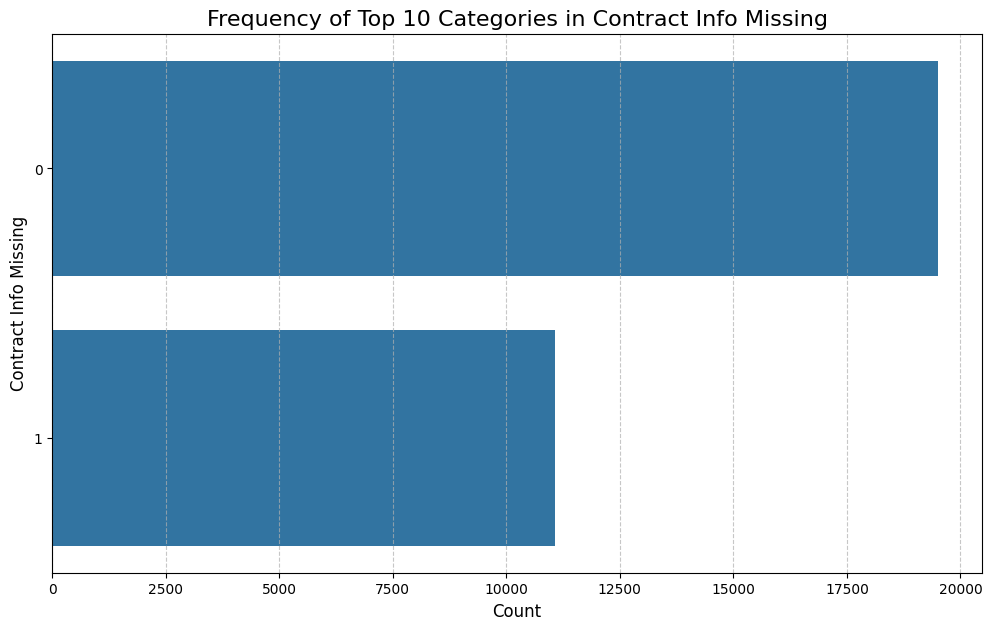

In [631]:
for col in cat_cols:

    top_categories = players_df[col].value_counts().nlargest(10).index
    
    plt.figure(figsize=(12, 7))
    sns.countplot(y=col, data=players_df, order=top_categories)
    plt.title(f'Frequency of Top 10 Categories in {col.replace("_", " ").title()}', fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(col.replace("_", " ").title(), fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

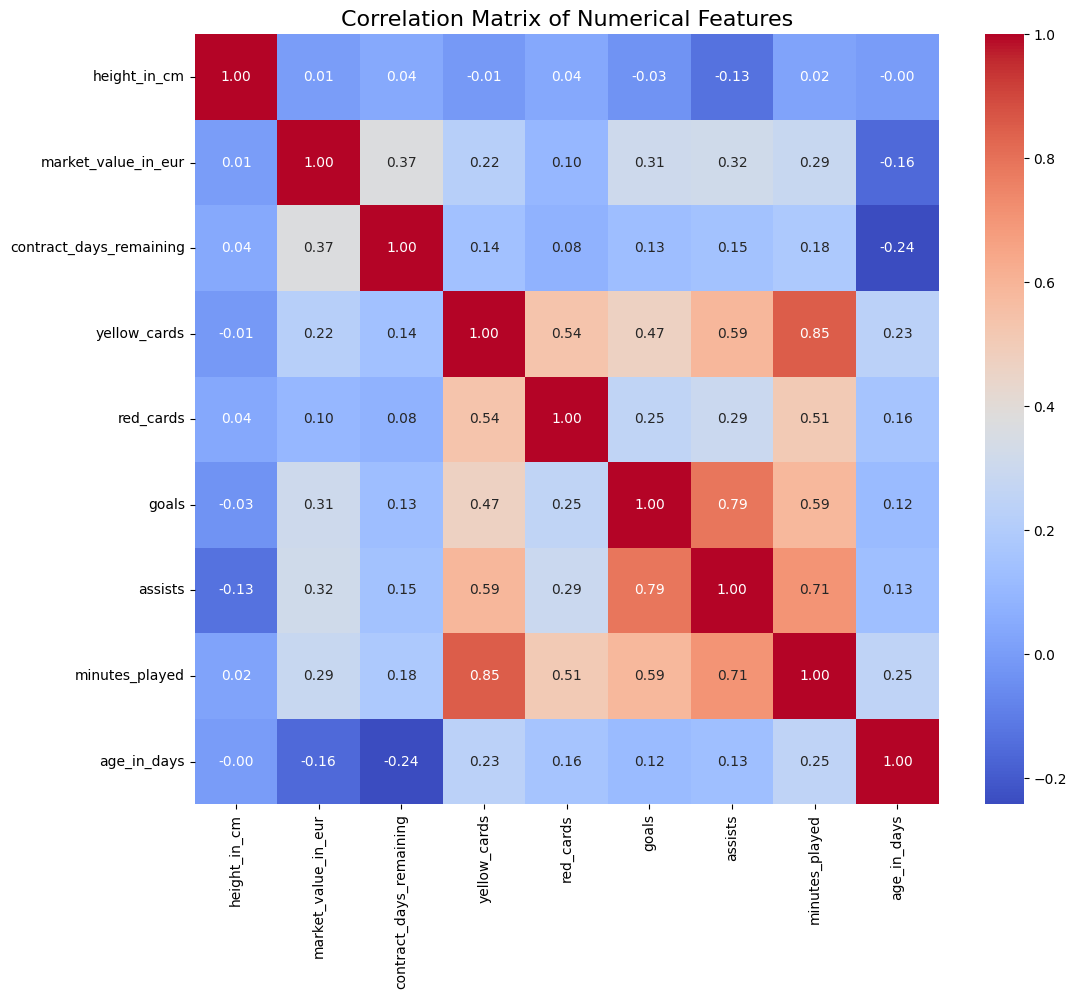

In [632]:
corr_matrix = players_df[num_cols].corr()

plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix, 
    annot=True,    
    cmap='coolwarm',
    fmt=".2f"       
)

plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()


## Modeling

In [43]:
model_df = players_df.drop(columns=['player_id', 'name', 'last_season','current_club_id'])

In [44]:
model_df = model_df.drop(columns=['agent_name'])

In [45]:
X = model_df.drop('market_value_in_eur', axis=1)
y = model_df['market_value_in_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
def fit_evaluate_and_tune_model(X_train, X_test, y_train, y_test, model_class, num_cols, cat_cols, log_transform_target=False):
    """
    Trains, evaluates, and optionally tunes a model using pre-split data.

    Args:
        X_train, X_test, y_train, y_test: The pre-split training and testing data.
        model_class: The model class to be used.
        num_cols (list): List of numerical column names.
        cat_cols (list): List of categorical column names.
        log_transform_target (bool): If True, applies a log(1+x) transform to the target.

    Returns:
        tuple: The final (best) pipeline and its test scores (R-squared, RMSE).
    """
    
    # --- Set up a more robust warning filter ---
    warnings.filterwarnings("ignore", category=UserWarning, message=".*Found unknown categories.*")
    warnings.filterwarnings("ignore", category=FutureWarning)

    try:
        # --- 1. Initial Setup ---
        # Make copies to avoid modifying the original dataframes passed to the function
        X_train_processed = X_train.copy()
        X_test_processed = X_test.copy()
        y_train_processed = y_train.copy()
        y_test_processed = y_test.copy()

        # --- Apply Log Transform if requested ---
        if log_transform_target:
            print("\nApplying log transform to the target variable.")
            y_train_processed = np.log1p(y_train_processed)
            y_test_processed = np.log1p(y_test_processed)
        
        # --- Data Validation Step ---
        for col in num_cols:
            if col in X_train_processed.columns:
                X_train_processed[col] = pd.to_numeric(X_train_processed[col], errors='coerce')
                X_test_processed[col] = pd.to_numeric(X_test_processed[col], errors='coerce')

        # --- 2. Define Preprocessing Pipeline ---
        numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
        categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, num_cols),
                ('cat', categorical_transformer, cat_cols)
            ],
            remainder='drop'
        )
        
        # --- 3. Evaluate Default Model ---
        default_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model_class(random_state=42) if 'random_state' in model_class().get_params() else model_class())
        ])
        
        default_pipeline.fit(X_train_processed, y_train_processed)
        y_pred_test_default = default_pipeline.predict(X_test_processed)
        y_pred_train_default = default_pipeline.predict(X_train_processed)

        # --- Inverse transform predictions if target was logged ---
        y_test_eval = np.expm1(y_test_processed) if log_transform_target else y_test_processed
        y_pred_test_eval = np.expm1(y_pred_test_default) if log_transform_target else y_pred_test_default
        y_train_eval = np.expm1(y_train_processed) if log_transform_target else y_train_processed
        y_pred_train_eval = np.expm1(y_pred_train_default) if log_transform_target else y_pred_train_default

        r2_test_default = r2_score(y_test_eval, y_pred_test_eval)
        rmse_test_default = np.sqrt(mean_squared_error(y_test_eval, y_pred_test_eval))
        r2_train_default = r2_score(y_train_eval, y_pred_train_eval)
        rmse_train_default = np.sqrt(mean_squared_error(y_train_eval, y_pred_train_eval))
        
        print(f"\n--- Initial {model_class.__name__} Evaluation ---")
        print(f"R-squared on Test Data: {r2_test_default:.2f}")
        print(f"R-squared on Training Data: {r2_train_default:.2f}")
        print(f"RMSE on Test Data: {rmse_test_default:,.2f}")
        print(f"RMSE on Training Data: {rmse_train_default:,.2f}")

        final_pipeline = default_pipeline
        final_r2 = r2_test_default
        final_rmse = rmse_test_default

        # --- 4. Conditional Hyperparameter Tuning ---
        if model_class in [RandomForestRegressor, XGBRegressor]:
            print("\n--- Starting Hyperparameter Tuning ---")
            
            # Define Model-Specific Parameter Grids
            if model_class == RandomForestRegressor:
                param_dist = {
                    'regressor__n_estimators': [100, 200, 500], 'regressor__max_depth': [10, 20, 30, None],
                    'regressor__min_samples_leaf': [1, 2, 4], 'regressor__max_features': ['sqrt', 'log2']
                }
            elif model_class == XGBRegressor:
                param_dist = {
                    'regressor__n_estimators': [100, 500, 1000], 'regressor__max_depth': [3, 5, 7, 10],
                    'regressor__learning_rate': [0.01, 0.05, 0.1], 'regressor__min_child_weight': [1, 5, 10]
                }

            # Randomized Search
            random_search = RandomizedSearchCV(estimator=default_pipeline, param_distributions=param_dist, n_iter=25, cv=5, verbose=1, random_state=42, n_jobs=-2, scoring='neg_root_mean_squared_error')
            random_search.fit(X_train_processed, y_train_processed)
            print("\nBest parameters from Randomized Search:", random_search.best_params_)

            # Grid Search
            best_params = random_search.best_params_
            param_grid = {}
            for key, value in best_params.items():
                if key in ['regressor__n_estimators']:
                    step = max(100, int(value * 0.2))
                    param_grid[key] = sorted(list(set([value, max(50, value - step), value + step])))
                elif isinstance(value, int) and value > 0: # Ensure value is at least 1
                    # Ensure the lower bound is at least 1
                    lower_bound = max(1, value - 1)
                    param_grid[key] = [lower_bound, value, value + 1]
                elif isinstance(value, float):
                    lower_bound = max(0.0, value * 0.9)
                    upper_bound = min(1.0, value * 1.1)
                    param_grid[key] = [lower_bound, value, upper_bound]
                else:
                    param_grid[key] = [value]
            
            grid_search = GridSearchCV(estimator=default_pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-2, scoring='neg_root_mean_squared_error')
            grid_search.fit(X_train_processed, y_train_processed)
            print("\nBest parameters from Grid Search:", grid_search.best_params_)
            
            # Overwrite final results with the tuned model's performance
            final_pipeline = grid_search.best_estimator_
            y_pred_test_tuned = final_pipeline.predict(X_test_processed)
            y_pred_train_tuned = final_pipeline.predict(X_train_processed)
            
            # Inverse transform predictions if target was logged
            y_test_eval = np.expm1(y_test_processed) if log_transform_target else y_test_processed
            y_pred_test_tuned_eval = np.expm1(y_pred_test_tuned) if log_transform_target else y_pred_test_tuned
            y_train_eval = np.expm1(y_train_processed) if log_transform_target else y_train_processed
            y_pred_train_tuned_eval = np.expm1(y_pred_train_tuned) if log_transform_target else y_pred_train_tuned

            final_r2 = r2_score(y_test_eval, y_pred_test_tuned_eval)
            final_rmse = np.sqrt(mean_squared_error(y_test_eval, y_pred_test_tuned_eval))
            r2_train_tuned = r2_score(y_train_eval, y_pred_train_tuned_eval)
            rmse_train_tuned = np.sqrt(mean_squared_error(y_train_eval, y_pred_train_tuned_eval))
            
            print(f"\n--- Tuned {model_class.__name__} Evaluation ---")
            print(f"R-squared on Test Data: {final_r2:.2f}")
            print(f"R-squared on Training Data: {r2_train_tuned:.2f}")
            print(f"RMSE on Test Data: {final_rmse:,.2f}")
            print(f"RMSE on Training Data: {rmse_train_tuned:,.2f}")
            
        return final_pipeline, final_r2, final_rmse
    finally:
        warnings.resetwarnings()

# 1. Define feature lists
numerical_features = [
    'height_in_cm', 'contract_days_remaining', 'yellow_cards', 
    'red_cards', 'goals', 'assists', 'minutes_played', 'age_in_days'
]
categorical_features = [
    'country_of_birth', 'country_of_citizenship',
    'sub_position', 'position', 'foot',
    'current_club_domestic_competition_id', 'current_club_name', 
    'contract_info_missing'
]

# 2. Create the train-test split
X = model_df.drop('market_value_in_eur', axis=1)
y = model_df['market_value_in_eur']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 3. Run all experiments using the same data split
print("\n--- EXPERIMENT 1: MODELS WITH ORIGINAL TARGET ---")
lr_pipeline, lr_r2, lr_rmse = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, LinearRegression, numerical_features, categorical_features
)
rf_pipeline, rf_r2, rf_rmse = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, RandomForestRegressor, numerical_features, categorical_features
)
xgb_pipeline, xgb_r2, xgb_rmse = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features
)


print("\n--- EXPERIMENT 2: MODELS WITH LOG-TRANSFORMED TARGET ---")
lr_pipeline_log, lr_r2_log, lr_rmse_log = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, LinearRegression, numerical_features, categorical_features, log_transform_target=True
)
rf_pipeline_log, rf_r2_log, rf_rmse_log = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, RandomForestRegressor, numerical_features, categorical_features, log_transform_target=True
)
xgb_pipeline_log, xgb_r2_log, xgb_rmse_log = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features, log_transform_target=True
)


--- EXPERIMENT 1: MODELS WITH ORIGINAL TARGET ---

--- Initial LinearRegression Evaluation ---
R-squared on Test Data: 0.35
R-squared on Training Data: 0.38
RMSE on Test Data: 5,099,226.28
RMSE on Training Data: 5,103,652.35

--- Initial RandomForestRegressor Evaluation ---
R-squared on Test Data: 0.64
R-squared on Training Data: 0.96
RMSE on Test Data: 3,794,145.19
RMSE on Training Data: 1,346,143.81

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best parameters from Randomized Search: {'regressor__n_estimators': 500, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': None}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best parameters from Grid Search: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 600}

--- Tuned RandomForestRegressor Evaluation ---
R-squared on Test Data: 0.57
R-squared on Tr

### Target

#### --- Initial LinearRegression Evaluation ---

R-squared on Test Data: 0.35

R-squared on Training Data: 0.38

RMSE on Test Data: 5,099,226.28

RMSE on Training Data: 5,103,652.35

#### --- Tuned RandomForestRegressor Evaluation ---

R-squared on Test Data: 0.57

R-squared on Training Data: 0.95

RMSE on Test Data: 4,127,609.95

RMSE on Training Data: 1,507,199.31

#### --- Tuned XGBRegressor Evaluation ---

R-squared on Test Data: 0.69

R-squared on Training Data: 0.93

RMSE on Test Data: 3,542,653.10

RMSE on Training Data: 1,698,010.46

### Log of Target

#### --- Initial LinearRegression Evaluation ---

R-squared on Test Data: 0.27

R-squared on Training Data: -0.01

RMSE on Test Data: 5,382,707.17

RMSE on Training Data: 6,519,539.32

#### --- Tuned RandomForestRegressor Evaluation ---

R-squared on Test Data: 0.37

R-squared on Training Data: 0.80

RMSE on Test Data: 5,023,226.90

RMSE on Training Data: 2,903,175.58

#### --- Tuned XGBRegressor Evaluation ---

R-squared on Test Data: 0.69

R-squared on Training Data: 0.88

RMSE on Test Data: 3,509,373.11

RMSE on Training Data: 2,213,755.10

#### Key Findings

XGBoost is the Top-Performing Model: Across all experiments, the XGBoost model consistently delivered the best results on the unseen test data.

Log Transformation is Effective for XGBoost: The best overall performance was achieved by the Tuned XGBoost model using the log-transformed target. This combination yielded the highest R-squared score (0.69) and the lowest Root Mean Squared Error (€3,509,373.11).

Log Transformation Reduces Overfitting: A key insight is that the log transform improved the XGBoost model's ability to generalize. It reduced the "Performance Drop" (the gap between training and test R-squared) from 0.24 to 0.19, indicating a more robust and reliable model.

Random Forest Performance Degraded with Log Transform: Interestingly, the performance of the RandomForestRegressor was worse when using the log-transformed target (R² dropped from 0.57 to 0.37). This suggests that for this specific dataset, the Random Forest model was leveraging the original scale of the target variable in its decision trees.

Linear Regression is Not Suitable: As confirmed by the low R-squared scores in both scenarios, a LinearRegression model is not capable of capturing the complex, non-linear patterns present in this dataset.

Final Recommendation
Based on this comprehensive analysis, the final recommended model is the Tuned XGBoost Regressor trained on the log-transformed market_value_in_eur target variable.

This model provides the best balance of predictive accuracy and generalization, explaining 70% of the variance in player market value while demonstrating the least amount of overfitting among the high-performing models.

Higher profile Premier League teams would not be very interested in players below a certain market value. If we filter out players under €10M, maybe we can improve performance

In [48]:
high_val_df = model_df[model_df['market_value_in_eur'] > 10000000]

In [49]:
model_df['market_value_in_eur'].mean(), model_df['market_value_in_eur'].std()

(1654497.9400993984, 6450610.738443693)

In [50]:
high_val_df['market_value_in_eur'].mean(), high_val_df['market_value_in_eur'].std()

(27647540.98360656, 21616824.256933)

In [51]:
X_2 = high_val_df.drop('market_value_in_eur', axis=1)
y_2 = high_val_df['market_value_in_eur']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [52]:
xgb_pipeline2, xgb_r2, xgb_rmse2 = fit_evaluate_and_tune_model(X_train_2, X_test_2, y_train_2, y_test_2, XGBRegressor, numerical_features, categorical_features, log_transform_target=True)


Applying log transform to the target variable.

--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.60
R-squared on Training Data: 0.98
RMSE on Test Data: 13,384,215.31
RMSE on Training Data: 3,006,033.09

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best parameters from Randomized Search: {'regressor__n_estimators': 500, 'regressor__min_child_weight': 5, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters from Grid Search: {'regressor__learning_rate': 0.11000000000000001, 'regressor__max_depth': 2, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 500}

--- Tuned XGBRegressor Evaluation ---
R-squared on Test Data: 0.68
R-squared on Training Data: 0.82
RMSE on Test Data: 11,870,921.38
RMSE on Training Data: 9,111,499.32


In [53]:
#New model with market values showed decreased performance

In [55]:
# 1. Access the trained XGBoost model and the preprocessor from the pipeline
xgb_model = xgb_pipeline_log.named_steps['regressor']
preprocessor = xgb_pipeline_log.named_steps['preprocessor']

# 2. Get the feature names after all transformations (like one-hot encoding)
# This is crucial for matching the scores to the correct feature names
feature_names = preprocessor.get_feature_names_out()

# 3. Get the feature importance scores from the model
importances = xgb_model.feature_importances_

# 4. Create a pandas Series for easy viewing and sorting
feature_importance_series = pd.Series(importances, index=feature_names)

# 5. Sort the values to see the most important features at the top
print("--- Top 15 Most Important Features (from XGBoost) ---")
print(feature_importance_series.nlargest(15))

--- Top 15 Most Important Features (from XGBoost) ---
num__contract_days_remaining                     0.053256
cat__country_of_citizenship_Turkey               0.044972
cat__current_club_domestic_competition_id_GB1    0.034360
cat__current_club_domestic_competition_id_L1     0.023264
cat__country_of_citizenship_Ukraine              0.021970
cat__current_club_domestic_competition_id_ES1    0.021796
cat__current_club_domestic_competition_id_FR1    0.021267
num__minutes_played                              0.017709
cat__current_club_domestic_competition_id_IT1    0.017004
cat__country_of_birth_Ukraine                    0.016001
cat__country_of_birth_UdSSR                      0.015251
cat__current_club_domestic_competition_id_DK1    0.013447
cat__current_club_domestic_competition_id_TR1    0.011070
cat__country_of_citizenship_Türkiye              0.010949
cat__current_club_domestic_competition_id_SC1    0.010938
dtype: float32


C:\Users\phill\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\phill\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\phill\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


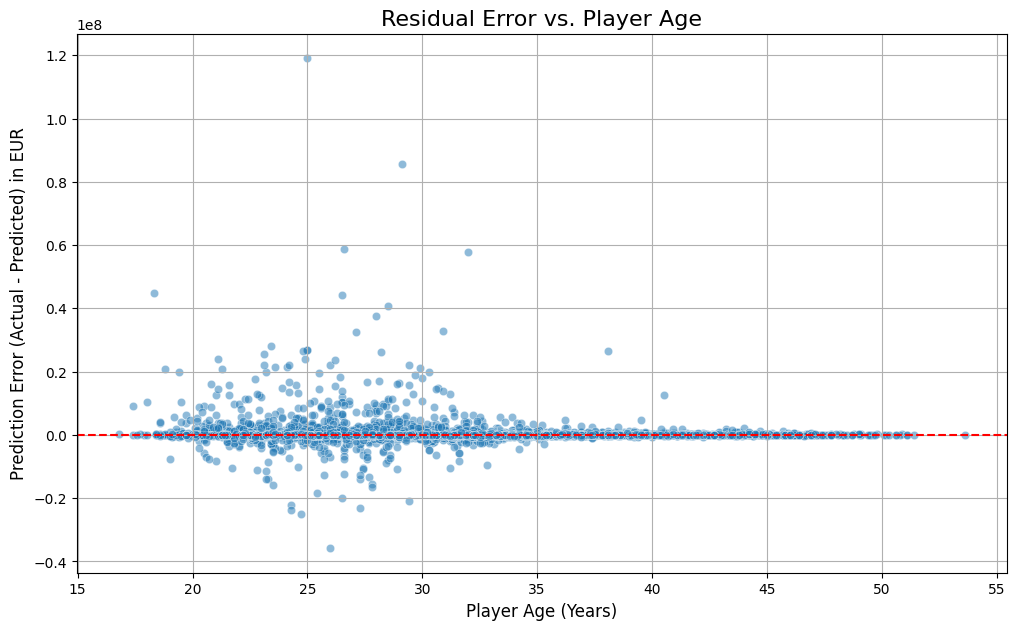

--- Top 20 Biggest Prediction Misses ---
                        name   age  actual_market_value  \
19437        Vinicius Junior  25.0          200000000.0   
18989                  Rodri  29.1          130000000.0   
20546         Victor Osimhen  26.6           70000000.0   
9295              Harry Kane  32.0           90000000.0   
29213          Ethan Nwaneri  18.3           55000000.0   
21144       Martín Zubimendi  26.5           60000000.0   
14771         Nicolò Barella  28.5           80000000.0   
17267          Marcus Thuram  28.0           75000000.0   
17466  Christoph Baumgartner  26.0           15000000.0   
14085        Bruno Fernandes  30.9           55000000.0   
22541           Eberechi Eze  27.1           55000000.0   
27977      Maghnes Akliouche  23.4           40000000.0   
20117             Marc Guéhi  25.0           45000000.0   
17788      Jonathan Burkardt  25.0           35000000.0   
2325            Lionel Messi  38.1           35000000.0   
23018   Giorgi 

In [83]:
# --- 1. Prepare Data for Analysis --
# Make predictions on the test set
y_pred_log = xgb_pipeline_log.predict(X_test)

# Inverse transform predictions and actuals to their original euro scale
y_pred_eur = np.expm1(y_pred_log)
y_test_eur = y_test

# Create a new DataFrame for analysis to avoid SettingWithCopyWarning
analysis_df = X_test.copy()
analysis_df['actual_market_value'] = y_test_eur
analysis_df['predicted_market_value'] = y_pred_eur
analysis_df['residual_error'] = analysis_df['actual_market_value'] - analysis_df['predicted_market_value']

# Convert age back from days to years for easier interpretation
analysis_df['age'] = (analysis_df['age_in_days'] / 365.25).round(1)


# --- 2. Analyze the Residuals (Plotting) ---
# A residual plot shows the errors vs. a feature

plt.figure(figsize=(12, 7))
sns.scatterplot(x='age', y='residual_error', data=analysis_df, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Error vs. Player Age', fontsize=16)
plt.xlabel('Player Age (Years)', fontsize=12)
plt.ylabel('Prediction Error (Actual - Predicted) in EUR', fontsize=12)
plt.grid(True)
plt.show()


# --- 3. Examine the Biggest Misses ---
analysis_df = analysis_df.merge(players_df[['name']], left_index=True, right_index=True, how='left')

# Sort by the absolute error to find the biggest misses overall
analysis_df['abs_error'] = analysis_df['residual_error'].abs()
biggest_misses = analysis_df.sort_values('abs_error', ascending=False)

# Display the top 20 biggest prediction errors
print("--- Top 20 Biggest Prediction Misses ---")
display_cols = ['name', 'age', 'actual_market_value', 'predicted_market_value', 'residual_error']
print(biggest_misses[display_cols].head(20))


print("\n--- Top 10 Players the Model UNDERESTIMATED (Predicted too low) ---")
print(biggest_misses.sort_values('residual_error', ascending=False)[display_cols].head(10))

print("\n--- Top 10 Players the Model OVERESTIMATED (Predicted too high) ---")
print(biggest_misses.sort_values('residual_error', ascending=True)[display_cols].head(10))

In [85]:
model_df.head()

,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,current_club_domestic_competition_id,current_club_name,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,age_in_days
0,Poland,Germany,Centre-Forward,Attack,right,184.000000,IT1,Società Sportiva Lazio S.p.A.,1000000.0,-26.0,1,19.0,0.0,48.0,25.0,8808.0,17213
1,Germany,Germany,Goalkeeper,Goalkeeper,left,190.000000,L1,Borussia Dortmund,750000.0,-26.0,1,4.0,2.0,0.0,0.0,13508.0,16424
2,Bulgaria,Bulgaria,Centre-Forward,Attack,Unknown,184.035063,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,-26.0,1,11.0,1.0,38.0,13.0,8788.0,16247
3,Brazil,Brazil,Centre-Back,Defender,Unknown,187.358271,IT1,Juventus Football Club,200000.0,-26.0,1,0.0,0.0,0.0,0.0,307.0,17245
4,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.000000,L1,FC Bayern München,100000.0,-26.0,1,0.0,0.0,0.0,0.0,1080.0,16200


### Feature Engineering

In [289]:
appearances_df.head()

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90
2,2234413_42792,2234413,42792,6251,465,2012-07-05,Sander Puri,ELQ,0,0,0,0,45
3,2234418_73333,2234418,73333,1274,6646,2012-07-05,Vegar Hedenstad,ELQ,0,0,0,0,90
4,2234421_122011,2234421,122011,195,3008,2012-07-05,Markus Henriksen,ELQ,0,0,0,1,90


In [290]:
clubs_df.head()

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,last_season
0,105,sv-darmstadt-98,SV Darmstadt 98,L1,NaN,27,25.6,13,48.1,1,Merck-Stadion am Böllenfalltor,17810,+€3.05m,NaN,2023
1,11127,ural-ekaterinburg,Ural Yekaterinburg,RU1,NaN,30,26.5,11,36.7,3,Yekaterinburg Arena,23000,+€880k,NaN,2023
2,114,besiktas-istanbul,Beşiktaş Jimnastik Kulübü,TR1,NaN,30,26.6,15,50.0,8,Beşiktaş Park,42445,€-25.26m,NaN,2024
3,12,as-rom,Associazione Sportiva Roma,IT1,NaN,26,26.3,18,69.2,17,Olimpico di Roma,70634,€-76.90m,NaN,2024
4,148,tottenham-hotspur,Tottenham Hotspur Football Club,GB1,NaN,30,25.5,21,70.0,18,Tottenham Hotspur Stadium,62850,€-120.05m,NaN,2024


In [534]:
#Here we are getting a history of all the clubs a player has played for
# Get club names and player_ids matched
apps_df = pd.merge(
    left=appearances_df[['player_id', 'player_club_id']], 
    right=clubs_df[['club_id']], 
    left_on='player_club_id', 
    right_on='club_id', 
    how='left'
)
apps_df = apps_df[['player_id', 'player_club_id']]

# Get unique clubs for each player before counting
unique_clubs_df = apps_df.drop_duplicates(subset=['player_id', 'player_club_id']).copy()

# Adds a column that counts the unique clubs for each player (1, 2, 3, etc.)
unique_clubs_df['club_number'] = unique_clubs_df.groupby('player_id').cumcount() + 1

# Transforms the data from a long to a wide format
club_history_df = unique_clubs_df.pivot(
    index='player_id', 
    columns='club_number', 
    values='player_club_id' 
)

# Renames the numbered columns while preserving the 'player_id' index name
club_history_df.columns = [f'club_{col}' for col in club_history_df.columns]
club_history_df.reset_index(inplace=True)

# Display the head of the FINAL DataFrame
club_history_df.head()

,player_id,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13
0,10,398.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,65,931.0,162.0,1091.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,77,506.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,80,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [633]:
#Merge new df with model df
model2_df = players_df.drop(columns=['name', 'last_season','current_club_id', 'current_club_name'])

model2_df = pd.merge(
    left=model2_df, 
    right=club_history_df, 
    on= 'player_id',
    how='left'
)

model2_df.head()

,player_id,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,age_in_days,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13
0,10,Poland,Germany,Centre-Forward,Attack,right,184.000000,ASBW Sport Marketing,IT1,1000000.0,-26.0,1,19.0,0.0,48.0,25.0,8808.0,17213,398.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26,Germany,Germany,Goalkeeper,Goalkeeper,left,190.000000,Neubauer 13 GmbH,L1,750000.0,-26.0,1,4.0,2.0,0.0,0.0,13508.0,16424,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,65,Bulgaria,Bulgaria,Centre-Forward,Attack,Unknown,184.035063,CSKA-AS-23 Ltd.,GR1,1000000.0,-26.0,1,11.0,1.0,38.0,13.0,8788.0,16247,931.0,162.0,1091.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,77,Brazil,Brazil,Centre-Back,Defender,Unknown,187.358271,Unknown,IT1,200000.0,-26.0,1,0.0,0.0,0.0,0.0,307.0,17245,506.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,80,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.000000,IFM,L1,100000.0,-26.0,1,0.0,0.0,0.0,0.0,1080.0,16200,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [634]:
#We can create a 'Age peak' metric for players centered around 27 years
# Convert age from days to years first
model2_df['age'] = model2_df['age_in_days'] / 365.25

# Create a feature that is low at the peak age (27) and higher for younger/older players
model2_df['age_peak_diff_sq'] = (model2_df['age'] - 27)**2

In [635]:
model2_df = model2_df.drop(columns=['age_in_days'])

In [636]:
#Lets create a per 90 minutes (one match) feature
model2_df['goals_per_90'] = (model2_df['goals'] * 90) / (model2_df['minutes_played'] + 1)
model2_df['assists_per_90'] = (model2_df['assists'] * 90) / (model2_df['minutes_played'] + 1)

In [637]:
club_games_df.head()

,game_id,club_id,own_goals,own_position,own_manager_name,opponent_id,opponent_goals,opponent_position,opponent_manager_name,hosting,is_win
0,2320450,1468.0,0.0,NaN,Holger Bachthaler,24.0,2.0,NaN,Armin Veh,Home,0
1,2320454,222.0,0.0,NaN,Volkan Uluc,79.0,2.0,NaN,Bruno Labbadia,Home,0
2,2320460,1.0,3.0,NaN,Jürgen Luginger,86.0,1.0,NaN,Robin Dutt,Home,1
3,2320472,2036.0,4.0,NaN,Frank Schmidt,72.0,5.0,NaN,Alexander Schmidt,Home,0
4,2321027,33.0,3.0,8.0,Jens Keller,41.0,3.0,9.0,Thorsten Fink,Home,0


In [638]:
#Instead of just club IDs or names, lets count their wins to effectively create a rating for the clubs they have played for
wins_series = club_games_df.groupby('club_id')['is_win'].sum()
wins_series = pd.Series(wins_series, name='wins')
wins_series.index.name = 'club_id'

# Convert the wins Series to a dictionary for fast lookups
wins_dict = wins_series.to_dict()

# Get the list of columns to update (e.g., 'club_1', 'club_2', ...)
club_cols = [f'club_{i}' for i in range(1, 14)]

for col in club_cols:
    # Check if the column exists in your DataFrame
    if col in model2_df.columns:
        # Use .map() to replace the club ID with its win count
        model2_df[col] = model2_df[col].map(wins_dict)

# After mapping, any clubs not in wins_dict or original NaNs will be NaN, fill these with 0.
model2_df[club_cols] = model2_df[club_cols].fillna(0).astype(int)

In [639]:
model2_df.head()

,player_id,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13,age,age_peak_diff_sq,goals_per_90,assists_per_90
0,10,Poland,Germany,Centre-Forward,Attack,right,184.000000,ASBW Sport Marketing,IT1,1000000.0,-26.0,1,19.0,0.0,48.0,25.0,8808.0,324,0,0,0,0,0,0,0,0,0,0,0,0,47.126626,405.081058,0.490408,0.255421
1,26,Germany,Germany,Goalkeeper,Goalkeeper,left,190.000000,Neubauer 13 GmbH,L1,750000.0,-26.0,1,4.0,2.0,0.0,0.0,13508.0,363,0,0,0,0,0,0,0,0,0,0,0,0,44.966461,322.793733,0.000000,0.000000
2,65,Bulgaria,Bulgaria,Centre-Forward,Attack,Unknown,184.035063,CSKA-AS-23 Ltd.,GR1,1000000.0,-26.0,1,11.0,1.0,38.0,13.0,8788.0,93,261,348,0,0,0,0,0,0,0,0,0,0,44.481862,305.615490,0.389123,0.133121
3,77,Brazil,Brazil,Centre-Back,Defender,Unknown,187.358271,Unknown,IT1,200000.0,-26.0,1,0.0,0.0,0.0,0.0,307.0,435,0,0,0,0,0,0,0,0,0,0,0,0,47.214237,408.615370,0.000000,0.000000
4,80,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.000000,IFM,L1,100000.0,-26.0,1,0.0,0.0,0.0,0.0,1080.0,490,0,0,0,0,0,0,0,0,0,0,0,0,44.353183,301.132952,0.000000,0.000000


In [640]:
appearances_df.head()

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90
2,2234413_42792,2234413,42792,6251,465,2012-07-05,Sander Puri,ELQ,0,0,0,0,45
3,2234418_73333,2234418,73333,1274,6646,2012-07-05,Vegar Hedenstad,ELQ,0,0,0,0,90
4,2234421_122011,2234421,122011,195,3008,2012-07-05,Markus Henriksen,ELQ,0,0,0,1,90


In [641]:
competitions_df.head()

,competition_id,name,type,country_id,country_name,domestic_league_code,confederation,is_major_national_league
0,CIT,italy-cup,domestic_cup,75,Italy,IT1,europa,False
1,NLSC,johan-cruijff-schaal,other,122,Netherlands,NL1,europa,False
2,GRP,kypello-elladas,domestic_cup,56,Greece,GR1,europa,False
3,POSU,supertaca-candido-de-oliveira,other,136,Portugal,PO1,europa,False
4,RUSS,russian-super-cup,other,141,Russia,RU1,europa,False


In [642]:
games_df.head()

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,url,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type
0,2321027,L1,2013,1. Matchday,2013-08-11,33.0,41.0,3.0,3.0,8.0,9.0,Jens Keller,Thorsten Fink,Veltins-Arena,61973.0,Manuel Gräfe,https://www.transfermarkt.co.uk/fc-schalke-04_...,4-2-3-1,4-2-3-1,FC Schalke 04,Hamburger SV,3:3,domestic_league
1,2321033,L1,2013,1. Matchday,2013-08-10,23.0,86.0,0.0,1.0,13.0,7.0,Torsten Lieberknecht,Robin Dutt,EINTRACHT-Stadion,23000.0,Deniz Aytekin,https://www.transfermarkt.co.uk/eintracht-brau...,4-3-2-1,4-3-1-2,Eintracht Braunschweig,Sportverein Werder Bremen von 1899,0:1,domestic_league
2,2321044,L1,2013,2. Matchday,2013-08-18,16.0,23.0,2.0,1.0,1.0,15.0,Jürgen Klopp,Torsten Lieberknecht,SIGNAL IDUNA PARK,80200.0,Peter Sippel,https://www.transfermarkt.co.uk/borussia-dortm...,4-2-3-1,4-3-2-1,Borussia Dortmund,Eintracht Braunschweig,2:1,domestic_league
3,2321060,L1,2013,3. Matchday,2013-08-25,23.0,24.0,0.0,2.0,18.0,11.0,Torsten Lieberknecht,Armin Veh,EINTRACHT-Stadion,23325.0,Wolfgang Stark,https://www.transfermarkt.co.uk/eintracht-brau...,4-3-2-1,4-2-3-1,Eintracht Braunschweig,Eintracht Frankfurt Fußball AG,0:2,domestic_league
4,2321072,L1,2013,5. Matchday,2013-09-14,16.0,41.0,6.0,2.0,1.0,15.0,Jürgen Klopp,Thorsten Fink,SIGNAL IDUNA PARK,80645.0,Tobias Welz,https://www.transfermarkt.co.uk/borussia-dortm...,4-2-3-1,3-5-2,Borussia Dortmund,Hamburger SV,6:2,domestic_league


In [643]:
#We want to adjust the goals, assists, and minutes for players based on who they played against, i.e. weigh them based off the 'toughness' of the competition
stats_df = pd.merge(
    left=appearances_df, 
    right=games_df[['game_id', 'home_club_id', 'away_club_id']],
    on='game_id',
    how='left'
)
stats_df.head()

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played,home_club_id,away_club_id
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90,853.0,10747.0
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90,8841.0,22783.0
2,2234413_42792,2234413,42792,6251,465,2012-07-05,Sander Puri,ELQ,0,0,0,0,45,6251.0,11915.0
3,2234418_73333,2234418,73333,1274,6646,2012-07-05,Vegar Hedenstad,ELQ,0,0,0,0,90,3779.0,1274.0
4,2234421_122011,2234421,122011,195,3008,2012-07-05,Markus Henriksen,ELQ,0,0,0,1,90,21532.0,195.0


In [644]:
#Keep the opponent id
stats_df['Opp'] = np.where(
    stats_df['player_club_id'] == stats_df['home_club_id'],  # Condition
    stats_df['away_club_id'],                               # Value if True
    stats_df['home_club_id']                                # Value if False
)

In [645]:
stats_df = stats_df.drop(columns=['appearance_id', 'game_id', 'player_current_club_id', 'date', 'player_name', 'yellow_cards', 'red_cards', 'home_club_id', 'away_club_id'])

In [646]:
wins_df = wins_series.reset_index()

In [647]:
#Normalize wins before adjusting goals, etc
norm_scaler = MinMaxScaler()
wins_df['normal_wins'] = norm_scaler.fit_transform(win_df[['wins']])

In [648]:
wins_df.head()

,club_id,wins,normal_wins
0,1.0,10,0.019920
1,2.0,16,0.031873
2,3.0,109,0.217131
3,4.0,34,0.067729
4,5.0,311,0.619522


In [649]:
#Merge on previous df
stats_df = pd.merge(
    left=stats_df, 
    right=wins_df[['club_id', 'normal_wins']],
    left_on='Opp',
    right_on='club_id',
    how='left'
)

In [650]:
#Create new cols for adjusted stats
cols = ['goals', 'assists', 'minutes_played']

for col in cols:
    stats_df[f'{col}_adjusted'] = stats_df['normal_wins'] * stats_df[col]

In [651]:
#Group before adding back to main df
weighted_stats = stats_df.groupby('player_id')[['normal_wins', 'goals_adjusted', 'assists_adjusted', 'minutes_played_adjusted']].sum()

In [652]:
weighted_stats = weighted_stats.reset_index()

In [653]:
weighted_stats

,player_id,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted
0,10,56.882470,15.645418,8.105578,3819.760956
1,26,66.874502,0.000000,0.000000,5924.866534
2,65,45.388446,11.332669,5.225100,3224.129482
3,77,1.583665,0.000000,0.000000,135.872510
4,80,3.609562,0.000000,0.000000,324.860558
...,...,...,...,...,...
25681,1310513,0.888446,0.000000,0.000000,4.087649
25682,1358447,0.308765,0.000000,0.000000,0.926295
25683,1375876,0.850598,0.000000,0.000000,3.589641
25684,1378362,0.191235,0.000000,0.000000,5.163347


In [654]:
model2_df = pd.merge(
    left=model2_df, 
    right=weighted_stats,
    on='player_id',
    how='left'
)

In [655]:
model2_df.sort_values('goals_adjusted', ascending=False).head()

,player_id,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13,age,age_peak_diff_sq,goals_per_90,assists_per_90,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted
3223,38253,Poland,Poland,Centre-Forward,Attack,right,185.0,Gol International,ES1,15000000.0,339.0,0,59.0,1.0,507.0,118.0,51228.0,363,490,502,0,0,0,0,0,0,0,0,0,0,36.925394,98.513437,0.890706,0.207304,264.065737,201.338645,47.874502,22247.352590
747,8198,Portugal,Portugal,Centre-Forward,Attack,right,187.0,Gestifute,GB1,15000000.0,-26.0,0,64.0,4.0,432.0,114.0,41150.0,502,435,370,0,0,0,0,0,0,0,0,0,0,40.465435,181.317930,0.944813,0.249326,222.049801,188.980080,41.145418,18945.011952
2325,28003,Argentina,Argentina,Right Winger,Attack,left,170.0,Unknown,FR1,35000000.0,-26.0,1,49.0,1.0,451.0,224.0,44380.0,502,419,0,0,0,0,0,0,0,0,0,0,0,38.086242,122.904768,0.914581,0.454248,244.456175,187.978088,88.653386,20756.914343
9295,132098,England,England,Centre-Forward,Attack,right,188.0,CK66,L1,90000000.0,704.0,0,52.0,0.0,346.0,85.0,39942.0,345,48,490,0,0,0,0,0,0,0,0,0,0,31.991786,24.917932,0.779611,0.191523,198.249004,120.683267,34.776892,16484.754980
9920,148455,Egypt,Egypt,Right Winger,Attack,left,175.0,Unknown,GB1,55000000.0,-26.0,0,20.0,0.0,292.0,144.0,41706.0,65,387,278,341,403,0,0,0,0,0,0,0,0,33.108830,37.317799,0.630110,0.310739,230.880478,119.866534,58.577689,18489.073705


In [656]:
#Realized way down that I needed a copy for future use
model5_df = model2_df.copy()

#Drop unneeded cols
model2_df = model2_df.drop(columns=['player_id', 'agent_name'])

In [657]:
model2_df.head()

,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,current_club_domestic_competition_id,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13,age,age_peak_diff_sq,goals_per_90,assists_per_90,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted
0,Poland,Germany,Centre-Forward,Attack,right,184.000000,IT1,1000000.0,-26.0,1,19.0,0.0,48.0,25.0,8808.0,324,0,0,0,0,0,0,0,0,0,0,0,0,47.126626,405.081058,0.490408,0.255421,56.882470,15.645418,8.105578,3819.760956
1,Germany,Germany,Goalkeeper,Goalkeeper,left,190.000000,L1,750000.0,-26.0,1,4.0,2.0,0.0,0.0,13508.0,363,0,0,0,0,0,0,0,0,0,0,0,0,44.966461,322.793733,0.000000,0.000000,66.874502,0.000000,0.000000,5924.866534
2,Bulgaria,Bulgaria,Centre-Forward,Attack,Unknown,184.035063,GR1,1000000.0,-26.0,1,11.0,1.0,38.0,13.0,8788.0,93,261,348,0,0,0,0,0,0,0,0,0,0,44.481862,305.615490,0.389123,0.133121,45.388446,11.332669,5.225100,3224.129482
3,Brazil,Brazil,Centre-Back,Defender,Unknown,187.358271,IT1,200000.0,-26.0,1,0.0,0.0,0.0,0.0,307.0,435,0,0,0,0,0,0,0,0,0,0,0,0,47.214237,408.615370,0.000000,0.000000,1.583665,0.000000,0.000000,135.872510
4,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.000000,L1,100000.0,-26.0,1,0.0,0.0,0.0,0.0,1080.0,490,0,0,0,0,0,0,0,0,0,0,0,0,44.353183,301.132952,0.000000,0.000000,3.609562,0.000000,0.000000,324.860558


In [317]:
model2_df.columns

Index(['country_of_birth', 'country_of_citizenship', 'sub_position',
       'position', 'foot', 'height_in_cm',
       'current_club_domestic_competition_id', 'market_value_in_eur',
       'contract_days_remaining', 'contract_info_missing', 'yellow_cards',
       'red_cards', 'goals', 'assists', 'minutes_played', 'club_1', 'club_2',
       'club_3', 'club_4', 'club_5', 'club_6', 'club_7', 'club_8', 'club_9',
       'club_10', 'club_11', 'club_12', 'club_13', 'age', 'age_peak_diff_sq',
       'goals_per_90', 'assists_per_90', 'normal_wins', 'goals_adjusted',
       'assists_adjusted', 'minutes_played_adjusted'],
      dtype='object')

In [318]:
numerical_features = ['height_in_cm', 'contract_days_remaining', 'yellow_cards',
                      'goals', 'assists', 'minutes_played', 'red_cards', 'club_1', 
                      'club_2', 'club_3', 'club_4', 'club_5', 'club_6', 'club_7', 
                      'club_8', 'club_9', 'club_10', 'club_11', 'club_12', 
                      'club_13', 'age', 'age_peak_diff_sq', 'goals_per_90', 
                      'assists_per_90','goals_adjusted', 'assists_adjusted', 
                      'minutes_played_adjusted'
                     ]

categorical_features = ['country_of_birth', 'country_of_citizenship', 'sub_position', 
                        'position', 'foot', 'current_club_domestic_competition_id',
                        'contract_info_missing'
                       ]
                        
X = model2_df.drop('market_value_in_eur', axis=1)
y = model2_df['market_value_in_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_pipeline3, xgb_r2, xgb_rmse = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features, log_transform_target=False
)

xgb_pipeline3_log, xgb_r2_log, xgb_rmse_log = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features, log_transform_target=True
)


--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.71
R-squared on Training Data: 0.98
RMSE on Test Data: 3,414,729.87
RMSE on Training Data: 947,440.83

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best parameters from Randomized Search: {'regressor__n_estimators': 1000, 'regressor__min_child_weight': 10, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters from Grid Search: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__min_child_weight': 10, 'regressor__n_estimators': 1200}

--- Tuned XGBRegressor Evaluation ---
R-squared on Test Data: 0.69
R-squared on Training Data: 0.95
RMSE on Test Data: 3,506,685.04
RMSE on Training Data: 1,519,024.95

Applying log transform to the target variable.

--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.65
R-squared on Training Data: 0.88
RMSE on Test 

## ---- Former Model ----

#### --- Tuned XGBRegressor Evaluation ---

R-squared on Test Data: 0.69

R-squared on Training Data: 0.93

RMSE on Test Data: 3,542,653.10

RMSE on Training Data: 1,698,010.46

#### --- Tuned XGBRegressor Evaluation (Log) ---

R-squared on Test Data: 0.69

R-squared on Training Data: 0.88

RMSE on Test Data: 3,509,373.11

RMSE on Training Data: 2,213,755.10

## ---- New Model ----

#### --- Tuned XGBRegressor Evaluation ---

R-squared on Test Data: 0.69

R-squared on Training Data: 0.95

RMSE on Test Data: 3,506,685.04

RMSE on Training Data: 1,519,024.95

#### --- Tuned XGBRegressor Evaluation (Log) ---

R-squared on Test Data: 0.69

R-squared on Training Data: 0.90

RMSE on Test Data: 3,501,733.18

RMSE on Training Data: 2,071,491.77

Extremely marginal improvement on RMSE and R-squared is basically the same, generalizes worse

--- Top 15 Most Important Features (from XGBoost) ---
num__contract_days_remaining                     0.110680
cat__country_of_citizenship_Turkey               0.048348
cat__current_club_domestic_competition_id_GB1    0.046204
num__minutes_played_adjusted                     0.035669
cat__country_of_citizenship_Ukraine              0.033078
cat__current_club_domestic_competition_id_FR1    0.029267
cat__current_club_domestic_competition_id_L1     0.027110
cat__country_of_birth_UdSSR                      0.023008
num__minutes_played                              0.021854
num__goals_adjusted                              0.019008
cat__current_club_domestic_competition_id_IT1    0.017712
cat__contract_info_missing_1                     0.017582
cat__country_of_birth_Ukraine                    0.017565
cat__country_of_citizenship_Greece               0.017463
cat__current_club_domestic_competition_id_ES1    0.017350
dtype: float32


C:\Users\phill\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\phill\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\phill\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


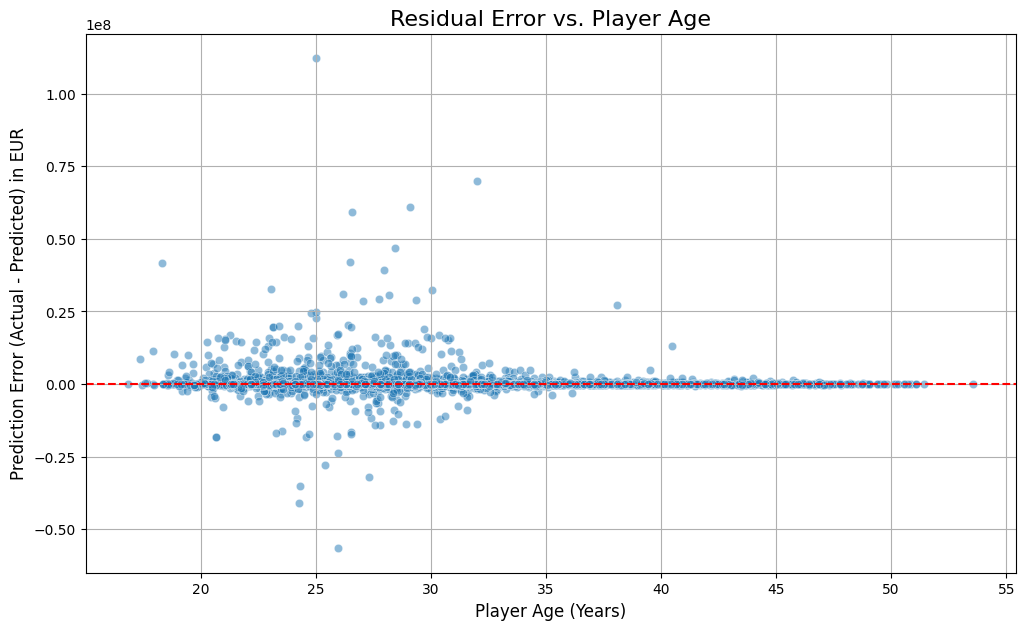

--- Top 20 Biggest Prediction Misses ---
                    name        age  actual_market_value  \
19437    Vinicius Junior  25.034908          200000000.0   
9295          Harry Kane  31.991786           90000000.0   
18989              Rodri  29.089665          130000000.0   
20546     Victor Osimhen  26.570842           70000000.0   
17536   Matthijs de Ligt  25.952088           40000000.0   
14771     Nicolò Barella  28.459959           80000000.0   
21144   Martín Zubimendi  26.475017           60000000.0   
29213      Ethan Nwaneri  18.346338           55000000.0   
24231   Santiago Gimenez  24.268309           37000000.0   
17267      Marcus Thuram  27.967146           75000000.0   
22166  Benoît Badiashile  24.331280           25000000.0   
30043            Murillo  23.058179           55000000.0   
14854      João Palhinha  30.045175           40000000.0   
22697      Nico González  27.301848           28000000.0   
18960    Ibrahima Konaté  26.168378           60000000.0   

In [319]:
# 1. Access the trained XGBoost model and the preprocessor from the pipeline
xgb_model = xgb_pipeline3_log.named_steps['regressor']
preprocessor = xgb_pipeline3_log.named_steps['preprocessor']

# 2. Get the feature names after all transformations (like one-hot encoding)
# This is crucial for matching the scores to the correct feature names
feature_names = preprocessor.get_feature_names_out()

# 3. Get the feature importance scores from the model
importances = xgb_model.feature_importances_

# 4. Create a pandas Series for easy viewing and sorting
feature_importance_series = pd.Series(importances, index=feature_names)

# 5. Sort the values to see the most important features at the top
print("--- Top 15 Most Important Features (from XGBoost) ---")
print(feature_importance_series.nlargest(15))

# --- 1. Prepare Data for Analysis --
# Make predictions on the test set
y_pred_log = xgb_pipeline3_log.predict(X_test)

# Inverse transform predictions and actuals to their original euro scale
y_pred_eur = np.expm1(y_pred_log)
y_test_eur = y_test

# Create a new DataFrame for analysis to avoid SettingWithCopyWarning
analysis_df = X_test.copy()
analysis_df['actual_market_value'] = y_test_eur
analysis_df['predicted_market_value'] = y_pred_eur
analysis_df['residual_error'] = analysis_df['actual_market_value'] - analysis_df['predicted_market_value']


# --- 2. Analyze the Residuals (Plotting) ---
# A residual plot shows the errors vs. a feature

plt.figure(figsize=(12, 7))
sns.scatterplot(x='age', y='residual_error', data=analysis_df, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Error vs. Player Age', fontsize=16)
plt.xlabel('Player Age (Years)', fontsize=12)
plt.ylabel('Prediction Error (Actual - Predicted) in EUR', fontsize=12)
plt.grid(True)
plt.show()


# --- 3. Examine the Biggest Misses ---
analysis_df = analysis_df.merge(players_df[['name']], left_index=True, right_index=True, how='left')

# Sort by the absolute error to find the biggest misses overall
analysis_df['abs_error'] = analysis_df['residual_error'].abs()
biggest_misses = analysis_df.sort_values('abs_error', ascending=False)

# Display the top 20 biggest prediction errors
print("--- Top 20 Biggest Prediction Misses ---")
display_cols = ['name', 'age', 'actual_market_value', 'predicted_market_value', 'residual_error']
print(biggest_misses[display_cols].head(20))


print("\n--- Top 10 Players the Model UNDERESTIMATED (Predicted too low) ---")
print(biggest_misses.sort_values('residual_error', ascending=False)[display_cols].head(10))

print("\n--- Top 10 Players the Model OVERESTIMATED (Predicted too high) ---")
print(biggest_misses.sort_values('residual_error', ascending=True)[display_cols].head(10))

In [320]:
model2_df.head()

,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,current_club_domestic_competition_id,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13,age,age_peak_diff_sq,goals_per_90,assists_per_90,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted
0,Poland,Germany,Centre-Forward,Attack,right,184.000000,IT1,1000000.0,-26.0,1,19.0,0.0,48.0,25.0,8808.0,324,0,0,0,0,0,0,0,0,0,0,0,0,47.126626,405.081058,0.490408,0.255421,56.882470,15.645418,8.105578,3819.760956
1,Germany,Germany,Goalkeeper,Goalkeeper,left,190.000000,L1,750000.0,-26.0,1,4.0,2.0,0.0,0.0,13508.0,363,0,0,0,0,0,0,0,0,0,0,0,0,44.966461,322.793733,0.000000,0.000000,66.874502,0.000000,0.000000,5924.866534
2,Bulgaria,Bulgaria,Centre-Forward,Attack,Unknown,184.035063,GR1,1000000.0,-26.0,1,11.0,1.0,38.0,13.0,8788.0,93,261,348,0,0,0,0,0,0,0,0,0,0,44.481862,305.615490,0.389123,0.133121,45.388446,11.332669,5.225100,3224.129482
3,Brazil,Brazil,Centre-Back,Defender,Unknown,187.358271,IT1,200000.0,-26.0,1,0.0,0.0,0.0,0.0,307.0,435,0,0,0,0,0,0,0,0,0,0,0,0,47.214237,408.615370,0.000000,0.000000,1.583665,0.000000,0.000000,135.872510
4,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.000000,L1,100000.0,-26.0,1,0.0,0.0,0.0,0.0,1080.0,490,0,0,0,0,0,0,0,0,0,0,0,0,44.353183,301.132952,0.000000,0.000000,3.609562,0.000000,0.000000,324.860558


In [321]:
#Country of citizenship and birth were some big indicators, but objectively they should not effect true player value, lets try taking them out
model3_df = model2_df.drop(columns=['country_of_birth', 'country_of_citizenship'])

In [322]:
numerical_features = ['height_in_cm', 'contract_days_remaining', 'yellow_cards',
                      'goals', 'assists', 'minutes_played', 'red_cards', 'club_1', 
                      'club_2', 'club_3', 'club_4', 'club_5', 'club_6', 'club_7', 
                      'club_8', 'club_9', 'club_10', 'club_11', 'club_12', 
                      'club_13', 'age', 'age_peak_diff_sq', 'goals_per_90', 
                      'assists_per_90','goals_adjusted', 'assists_adjusted', 
                      'minutes_played_adjusted'
                     ]

categorical_features = ['sub_position', 'position', 'foot', 
                        'current_club_domestic_competition_id','contract_info_missing'
                       ]
                        
X = model3_df.drop('market_value_in_eur', axis=1)
y = model3_df['market_value_in_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_pipeline4, xgb_r2, xgb_rmse = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features, log_transform_target=False
)

xgb_pipeline4_log, xgb_r2_log, xgb_rmse_log = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features, log_transform_target=True
)


--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.70
R-squared on Training Data: 0.98
RMSE on Test Data: 3,479,312.70
RMSE on Training Data: 842,095.60

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best parameters from Randomized Search: {'regressor__n_estimators': 1000, 'regressor__min_child_weight': 10, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters from Grid Search: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__min_child_weight': 11, 'regressor__n_estimators': 1200}

--- Tuned XGBRegressor Evaluation ---
R-squared on Test Data: 0.69
R-squared on Training Data: 0.95
RMSE on Test Data: 3,541,323.43
RMSE on Training Data: 1,483,507.48

Applying log transform to the target variable.

--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.59
R-squared on Training Data: 0.91
RMSE on Test 

Dropping was not effective and decreased performance

In [323]:
stats_df.head()

,player_id,player_club_id,competition_id,goals,assists,minutes_played,Opp,club_id,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted
0,38004,853,CLQ,2,0,90,10747.0,10747.0,0.001992,0.003984,0.000000,0.179283
1,79232,8841,ELQ,0,0,90,22783.0,22783.0,0.019920,0.000000,0.000000,1.792829
2,42792,6251,ELQ,0,0,45,11915.0,11915.0,0.000000,0.000000,0.000000,0.000000
3,73333,1274,ELQ,0,0,90,3779.0,3779.0,0.003984,0.000000,0.000000,0.358566
4,122011,195,ELQ,0,1,90,21532.0,21532.0,0.017928,0.000000,0.017928,1.613546


In [369]:
competitions_df.head()

,competition_id,name,type,country_id,country_name,domestic_league_code,confederation,is_major_national_league,country_score,int_score,comp_score
0,CIT,italy-cup,domestic_cup,75,Italy,IT1,europa,False,80.946,NaN,60.7095
1,NLSC,johan-cruijff-schaal,other,122,Netherlands,NL1,europa,False,58.116,NaN,29.0580
2,GRP,kypello-elladas,domestic_cup,56,Greece,GR1,europa,False,34.412,NaN,25.8090
3,POSU,supertaca-candido-de-oliveira,other,136,Portugal,PO1,europa,False,52.766,NaN,26.3830
4,RUSS,russian-super-cup,other,141,Russia,RU1,europa,False,18.299,NaN,9.1495


In [330]:
competitions_df['country_name'].unique()

array(['Italy', 'Netherlands', 'Greece', 'Portugal', 'Russia', 'Spain',
       nan, 'Denmark', 'France', 'Belgium', 'England', 'Ukraine',
       'Turkey', 'Germany', 'Scotland'], dtype=object)

In [367]:
competitions_df['type'].unique()

array(['domestic_cup', 'other', 'international_cup', 'domestic_league',
       55], dtype=object)

In [368]:
competitions_df[competitions_df['type'] == 'other']

,competition_id,name,type,country_id,country_name,domestic_league_code,confederation,is_major_national_league,country_score,int_score,comp_score
1,NLSC,johan-cruijff-schaal,other,122,Netherlands,NL1,europa,False,58.116,NaN,29.0580
3,POSU,supertaca-candido-de-oliveira,other,136,Portugal,PO1,europa,False,52.766,NaN,26.3830
4,RUSS,russian-super-cup,other,141,Russia,RU1,europa,False,18.299,NaN,9.1495
5,SUC,supercopa,other,157,Spain,ES1,europa,False,74.953,NaN,37.4765
15,BESC,belgian-supercup,other,19,Belgium,BE1,europa,False,51.150,NaN,25.5750
19,CGB,efl-cup,other,189,England,GB1,europa,False,90.839,NaN,45.4195
24,UKRS,ukrainian-super-cup,other,177,Ukraine,UKR1,europa,False,18.475,NaN,9.2375
31,GBCS,community-shield,other,189,England,GB1,europa,False,90.839,NaN,45.4195
36,SCI,supercoppa-italiana,other,75,Italy,IT1,europa,False,80.946,NaN,40.4730
39,DFL,dfl-supercup,other,40,Germany,L1,europa,False,71.117,NaN,35.5585


In [370]:
competitions_df[competitions_df['type'] == 'international_cup']['name']

6                                  uefa-super-cup
8                                   europa-league
17                         uefa-conference-league
18                    europa-league-qualifikation
21    uefa-europa-conference-league-qualifikation
27                          uefa-champions-league
38            uefa-champions-league-qualifikation
Name: name, dtype: object

In [389]:
#Map by country (coefficient score from UEFA)
country_value_map = {
    'England': 90.839,
    'Spain': 74.953,
    'Germany': 71.117,
    'Italy': 80.946,
    'France': 65.177,
    'Portugal': 52.766,
    'Netherlands': 58.116,
    'Belgium': 51.150,
    'Turkey': 41,
    'Russia': 18.299,
    'Greece': 34.412,
    'Ukraine': 18.475,
    'Denmark': 30.481,
    'Scotland': 26.125
}

competitions_df['country_score'] = competitions_df['country_name'].map(country_value_map)

In [391]:
#My own weights based off domain knowledge, relative to country score
int_map =  {
    'uefa-super-cup': 75,
    'europa-league': 80,
    'uefa-conference-league': 65,
    'europa-league-qualifikation': 55,
    'uefa-europa-conference-league-qualifikation': 45,
    'uefa-champions-league': 115,
    'uefa-champions-league-qualifikation': 65
}

competitions_df['int_score'] = competitions_df['name'].map(int_map)

# Define list of conditions
conditions = [
    competitions_df['type'] == 'domestic_cup',
    competitions_df['type'] == 'domestic_league',
    competitions_df['type'] == 'other',
    competitions_df['type'] == 'international_cup'
]

# Define the list of choices that correspond to each condition
choices = [
    competitions_df['country_score'] * 0.75,
    competitions_df['country_score'],
    competitions_df['country_score'] * 0.5,
    competitions_df['int_score']
]

# 3. Create the new column using np.select
# The 'default' value is used if none of the conditions are met.
competitions_df['comp_score'] = np.select(conditions, choices, default=0)

In [394]:
#Fix KLUB competition
competitions_df['comp_score'] = competitions_df['comp_score'].fillna(55)

In [397]:
competitions_df[['name', 'comp_score']].sort_values('comp_score',ascending=False)

,name,comp_score
27,uefa-champions-league,115.00000
16,premier-league,90.83900
11,serie-a,80.94600
8,europa-league,80.00000
6,uefa-super-cup,75.00000
9,laliga,74.95300
33,bundesliga,71.11700
22,fa-cup,68.12925
10,ligue-1,65.17700
38,uefa-champions-league-qualifikation,65.00000


In [398]:
#Normalize comp_score before adjusting goals, etc
competitions_df['normal_score'] = norm_scaler.fit_transform(competitions_df[['comp_score']])

In [404]:
stats_df = pd.merge(
    left=stats_df, 
    right=competitions_df[['normal_score', 'competition_id']],
    on='competition_id',
    how='left'
)

In [405]:
stats_df.head()

,player_id,player_club_id,competition_id,goals,assists,minutes_played,Opp,club_id,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted,normal_score
0,38004,853,CLQ,2,0,90,10747.0,10747.0,0.001992,0.003984,0.000000,0.179283,0.527636
1,79232,8841,ELQ,0,0,90,22783.0,22783.0,0.019920,0.000000,0.000000,1.792829,0.433163
2,42792,6251,ELQ,0,0,45,11915.0,11915.0,0.000000,0.000000,0.000000,0.000000,0.433163
3,73333,1274,ELQ,0,0,90,3779.0,3779.0,0.003984,0.000000,0.000000,0.358566,0.433163
4,122011,195,ELQ,0,1,90,21532.0,21532.0,0.017928,0.000000,0.017928,1.613546,0.433163


In [406]:
# List of the already-adjusted columns to further adjust
adjusted_cols = ['goals_adjusted', 'assists_adjusted', 'minutes_played_adjusted']

# Loop through each column and multiply by the competition score
for col in adjusted_cols:
    stats_df[col] = stats_df[col] * stats_df['normal_score']

stats_df.head()

,player_id,player_club_id,competition_id,goals,assists,minutes_played,Opp,club_id,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted,normal_score
0,38004,853,CLQ,2,0,90,10747.0,10747.0,0.001992,0.002102,0.000000,0.094596,0.527636
1,79232,8841,ELQ,0,0,90,22783.0,22783.0,0.019920,0.000000,0.000000,0.776587,0.433163
2,42792,6251,ELQ,0,0,45,11915.0,11915.0,0.000000,0.000000,0.000000,0.000000,0.433163
3,73333,1274,ELQ,0,0,90,3779.0,3779.0,0.003984,0.000000,0.000000,0.155317,0.433163
4,122011,195,ELQ,0,1,90,21532.0,21532.0,0.017928,0.000000,0.007766,0.698928,0.433163


In [407]:
model2_df.head()

,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,current_club_domestic_competition_id,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13,age,age_peak_diff_sq,goals_per_90,assists_per_90,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted
0,Poland,Germany,Centre-Forward,Attack,right,184.000000,IT1,1000000.0,-26.0,1,19.0,0.0,48.0,25.0,8808.0,324,0,0,0,0,0,0,0,0,0,0,0,0,47.126626,405.081058,0.490408,0.255421,56.882470,15.645418,8.105578,3819.760956
1,Germany,Germany,Goalkeeper,Goalkeeper,left,190.000000,L1,750000.0,-26.0,1,4.0,2.0,0.0,0.0,13508.0,363,0,0,0,0,0,0,0,0,0,0,0,0,44.966461,322.793733,0.000000,0.000000,66.874502,0.000000,0.000000,5924.866534
2,Bulgaria,Bulgaria,Centre-Forward,Attack,Unknown,184.035063,GR1,1000000.0,-26.0,1,11.0,1.0,38.0,13.0,8788.0,93,261,348,0,0,0,0,0,0,0,0,0,0,44.481862,305.615490,0.389123,0.133121,45.388446,11.332669,5.225100,3224.129482
3,Brazil,Brazil,Centre-Back,Defender,Unknown,187.358271,IT1,200000.0,-26.0,1,0.0,0.0,0.0,0.0,307.0,435,0,0,0,0,0,0,0,0,0,0,0,0,47.214237,408.615370,0.000000,0.000000,1.583665,0.000000,0.000000,135.872510
4,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.000000,L1,100000.0,-26.0,1,0.0,0.0,0.0,0.0,1080.0,490,0,0,0,0,0,0,0,0,0,0,0,0,44.353183,301.132952,0.000000,0.000000,3.609562,0.000000,0.000000,324.860558


In [409]:
weighted_new = stats_df.groupby('player_id')[['goals_adjusted', 'assists_adjusted', 'minutes_played_adjusted']].sum()

weighted_new = weighted_new.reset_index()

In [410]:
weighted_new

,player_id,goals_adjusted,assists_adjusted,minutes_played_adjusted
0,10,10.386286,5.424367,2442.465084
1,26,0.000000,0.000000,4243.398388
2,65,7.560985,3.767897,2228.255138
3,77,0.000000,0.000000,69.158238
4,80,0.000000,0.000000,167.837285
...,...,...,...,...
25681,1310513,0.000000,0.000000,2.163625
25682,1358447,0.000000,0.000000,0.367545
25683,1375876,0.000000,0.000000,0.316250
25684,1378362,0.000000,0.000000,2.048768


In [658]:
model5_df = pd.merge(
    left=model5_df, 
    right=weighted_new,
    on='player_id',
    how='left'
)

In [659]:
model5_df.columns

Index(['player_id', 'country_of_birth', 'country_of_citizenship',
       'sub_position', 'position', 'foot', 'height_in_cm', 'agent_name',
       'current_club_domestic_competition_id', 'market_value_in_eur',
       'contract_days_remaining', 'contract_info_missing', 'yellow_cards',
       'red_cards', 'goals', 'assists', 'minutes_played', 'club_1', 'club_2',
       'club_3', 'club_4', 'club_5', 'club_6', 'club_7', 'club_8', 'club_9',
       'club_10', 'club_11', 'club_12', 'club_13', 'age', 'age_peak_diff_sq',
       'goals_per_90', 'assists_per_90', 'normal_wins', 'goals_adjusted_x',
       'assists_adjusted_x', 'minutes_played_adjusted_x', 'goals_adjusted_y',
       'assists_adjusted_y', 'minutes_played_adjusted_y'],
      dtype='object')

In [660]:
model5_df = model5_df.drop(columns=['normal_wins', 'goals_adjusted_x','assists_adjusted_x', 'minutes_played_adjusted_x','agent_name'])
model5_with_id = model5_df.copy()
model5_df = model5_df.drop(columns=['player_id'])
model5_df.head()

,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,current_club_domestic_competition_id,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13,age,age_peak_diff_sq,goals_per_90,assists_per_90,goals_adjusted_y,assists_adjusted_y,minutes_played_adjusted_y
0,Poland,Germany,Centre-Forward,Attack,right,184.000000,IT1,1000000.0,-26.0,1,19.0,0.0,48.0,25.0,8808.0,324,0,0,0,0,0,0,0,0,0,0,0,0,47.126626,405.081058,0.490408,0.255421,10.386286,5.424367,2442.465084
1,Germany,Germany,Goalkeeper,Goalkeeper,left,190.000000,L1,750000.0,-26.0,1,4.0,2.0,0.0,0.0,13508.0,363,0,0,0,0,0,0,0,0,0,0,0,0,44.966461,322.793733,0.000000,0.000000,0.000000,0.000000,4243.398388
2,Bulgaria,Bulgaria,Centre-Forward,Attack,Unknown,184.035063,GR1,1000000.0,-26.0,1,11.0,1.0,38.0,13.0,8788.0,93,261,348,0,0,0,0,0,0,0,0,0,0,44.481862,305.615490,0.389123,0.133121,7.560985,3.767897,2228.255138
3,Brazil,Brazil,Centre-Back,Defender,Unknown,187.358271,IT1,200000.0,-26.0,1,0.0,0.0,0.0,0.0,307.0,435,0,0,0,0,0,0,0,0,0,0,0,0,47.214237,408.615370,0.000000,0.000000,0.000000,0.000000,69.158238
4,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.000000,L1,100000.0,-26.0,1,0.0,0.0,0.0,0.0,1080.0,490,0,0,0,0,0,0,0,0,0,0,0,0,44.353183,301.132952,0.000000,0.000000,0.000000,0.000000,167.837285


In [572]:
numerical_features = ['height_in_cm', 'contract_days_remaining', 'yellow_cards',
                      'goals', 'assists', 'minutes_played', 'red_cards', 'club_1', 
                      'club_2', 'club_3', 'club_4', 'club_5', 'club_6', 'club_7', 
                      'club_8', 'club_9', 'club_10', 'club_11', 'club_12', 
                      'club_13', 'age', 'age_peak_diff_sq', 'goals_per_90', 
                      'assists_per_90','goals_adjusted_y', 'assists_adjusted_y', 
                      'minutes_played_adjusted_y'
                     ]

categorical_features = ['country_of_birth', 'country_of_citizenship', 'sub_position', 
                        'position', 'foot', 'current_club_domestic_competition_id',
                        'contract_info_missing'
                       ]
                        
X = model5_df.drop('market_value_in_eur', axis=1)
y = model5_df['market_value_in_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_pipeline5, xgb_r2, xgb_rmse = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features, log_transform_target=False
)

xgb_pipeline5_log, xgb_r2_log, xgb_rmse_log = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features, log_transform_target=True
)


--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.73
R-squared on Training Data: 0.98
RMSE on Test Data: 3,266,245.32
RMSE on Training Data: 917,423.17

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best parameters from Randomized Search: {'regressor__n_estimators': 1000, 'regressor__min_child_weight': 5, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters from Grid Search: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__min_child_weight': 6, 'regressor__n_estimators': 1200}

--- Tuned XGBRegressor Evaluation ---
R-squared on Test Data: 0.73
R-squared on Training Data: 0.95
RMSE on Test Data: 3,252,969.65
RMSE on Training Data: 1,377,905.32

Applying log transform to the target variable.

--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.63
R-squared on Training Data: 0.87
RMSE on Test Da

### Analysis of Results

R-squared of 0.73: Model now explains 73% of the variance in player market value.

Reduced RMSE: Lowered average prediction error to €3.25 million. This is a substantial improvement in accuracy compared to previous models.

Overfitting is Stable: The gap between the training (0.95) and test (0.73) scores is similar to previous models. The key is that the performance on the unseen test data has improved.

--- Top 15 Most Important Features (from XGBoost) ---
num__assists_adjusted_y                          0.114919
num__age                                         0.105254
num__minutes_played_adjusted_y                   0.093831
num__contract_days_remaining                     0.089549
num__goals_adjusted_y                            0.077299
cat__current_club_domestic_competition_id_GB1    0.065447
cat__sub_position_Centre-Forward                 0.042545
num__age_peak_diff_sq                            0.013204
num__club_3                                      0.013117
num__club_1                                      0.012846
num__club_2                                      0.012037
cat__sub_position_Defensive Midfield             0.011281
num__goals                                       0.010963
cat__position_Midfield                           0.010631
num__club_4                                      0.010302
dtype: float32


C:\Users\phill\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\phill\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\phill\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


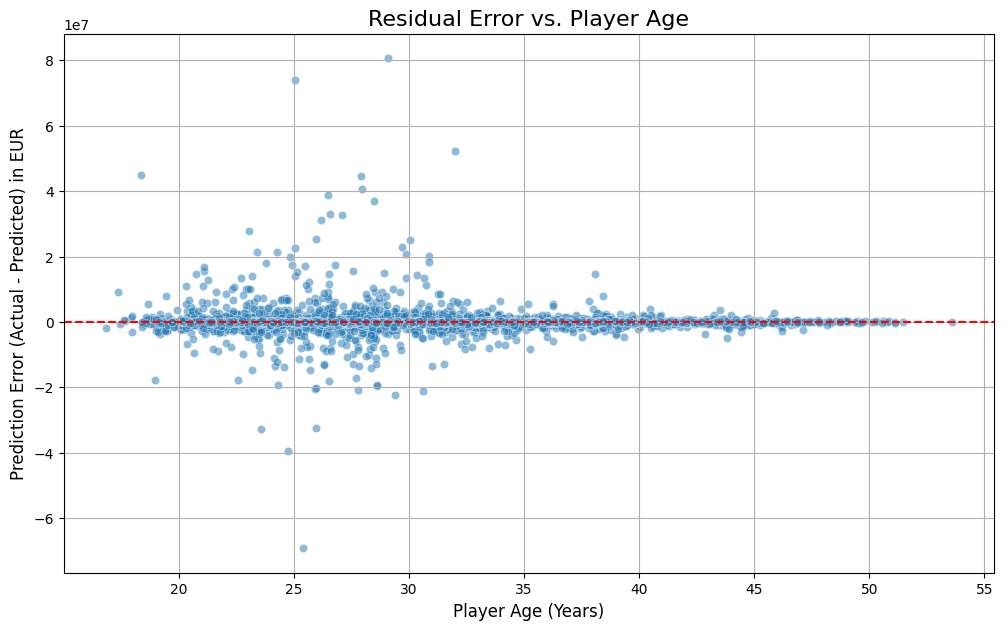

--- Top 20 Biggest Prediction Misses ---
                    name        age  actual_market_value  \
18989              Rodri  29.089665          130000000.0   
19437    Vinicius Junior  25.034908          200000000.0   
20406      Ferran Torres  25.401780           28000000.0   
9295          Harry Kane  31.991786           90000000.0   
29213      Ethan Nwaneri  18.346338           55000000.0   
20686   Lautaro Martínez  27.923340           95000000.0   
17267      Marcus Thuram  27.967146           75000000.0   
21178    Alphonso Davies  24.725530           50000000.0   
21144   Martín Zubimendi  26.475017           60000000.0   
14771     Nicolò Barella  28.459959           80000000.0   
20546     Victor Osimhen  26.570842           70000000.0   
22541       Eberechi Eze  27.071869           55000000.0   
25590  Ander Barrenetxea  23.575633           18000000.0   
17536   Matthijs de Ligt  25.952088           40000000.0   
18960    Ibrahima Konaté  26.168378           60000000.0   

In [573]:
# 1. Access the trained XGBoost model and the preprocessor from the pipeline
xgb_model = xgb_pipeline5.named_steps['regressor']
preprocessor = xgb_pipeline5.named_steps['preprocessor']

# 2. Get the feature names after all transformations (like one-hot encoding)
# This is crucial for matching the scores to the correct feature names
feature_names = preprocessor.get_feature_names_out()

# 3. Get the feature importance scores from the model
importances = xgb_model.feature_importances_

# 4. Create a pandas Series for easy viewing and sorting
feature_importance_series = pd.Series(importances, index=feature_names)

# 5. Sort the values to see the most important features at the top
print("--- Top 15 Most Important Features (from XGBoost) ---")
print(feature_importance_series.nlargest(15))

# --- 1. Prepare Data for Analysis --
# Make predictions on the test set
y_pred = xgb_pipeline5.predict(X_test)

y_pred_eur = y_pred
y_test_eur = y_test

# Create a new DataFrame for analysis to avoid SettingWithCopyWarning
analysis_df = X_test.copy()
analysis_df['actual_market_value'] = y_test_eur
analysis_df['predicted_market_value'] = y_pred_eur
analysis_df['residual_error'] = analysis_df['actual_market_value'] - analysis_df['predicted_market_value']


# --- 2. Analyze the Residuals (Plotting) ---
# A residual plot shows the errors vs. a feature

plt.figure(figsize=(12, 7))
sns.scatterplot(x='age', y='residual_error', data=analysis_df, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Error vs. Player Age', fontsize=16)
plt.xlabel('Player Age (Years)', fontsize=12)
plt.ylabel('Prediction Error (Actual - Predicted) in EUR', fontsize=12)
plt.grid(True)
plt.show()


# --- 3. Examine the Biggest Misses ---
analysis_df = analysis_df.merge(players_df[['name']], left_index=True, right_index=True, how='left')

# Sort by the absolute error to find the biggest misses overall
analysis_df['abs_error'] = analysis_df['residual_error'].abs()
biggest_misses = analysis_df.sort_values('abs_error', ascending=False)

# Display the top 20 biggest prediction errors
print("--- Top 20 Biggest Prediction Misses ---")
display_cols = ['name', 'age', 'actual_market_value', 'predicted_market_value', 'residual_error']
print(biggest_misses[display_cols].head(20))


print("\n--- Top 10 Players the Model UNDERESTIMATED (Predicted too low) ---")
print(biggest_misses.sort_values('residual_error', ascending=False)[display_cols].head(10))

print("\n--- Top 10 Players the Model OVERESTIMATED (Predicted too high) ---")
print(biggest_misses.sort_values('residual_error', ascending=True)[display_cols].head(10))

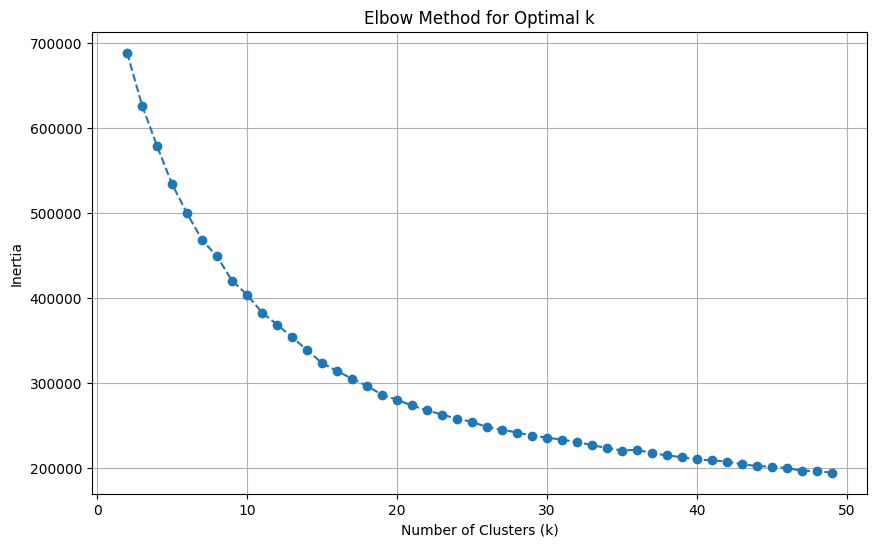

In [586]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# --- 1. Select and Prepare the Data ---
numerical_features = [
    'height_in_cm', 'contract_days_remaining', 'yellow_cards',
    'goals', 'assists', 'minutes_played', 'red_cards', 'club_1',
    'club_2', 'club_3', 'club_4', 'club_5', 'club_6', 'club_7',
    'club_8', 'club_9', 'club_10', 'club_11', 'club_12',
    'club_13', 'age', 'age_peak_diff_sq', 'goals_per_90',
    'assists_per_90','goals_adjusted_y', 'assists_adjusted_y',
    'minutes_played_adjusted_y'
]

# Create a new DataFrame with only the features for clustering
cluster_df = model5_df[numerical_features].copy()

# --- 2. Create a Preprocessing Pipeline ---
# K-Means requires data to be scaled and have no missing values.
# The imputer handles any NaNs, and the scaler standardizes the features.
preprocessing_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Apply the preprocessing to your data
X_processed = preprocessing_pipeline.fit_transform(cluster_df)


# --- 3. Find the Optimal Number of Clusters (k) using the Elbow Method ---
# We calculate the inertia (sum of squared distances to the closest centroid)
# for a range of k values. The "elbow" point is the optimal k.
inertia_scores = []
k_range = range(2, 50) # Test k from 2 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    inertia_scores.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [664]:
# --- 4. Fit the Final K-Means Model ---
# Based on the elbow plot, choose the optimal number of clusters. We can probably go beyond 10 and still get meaningful distinction, but too many starts to create very specific categories
optimal_k = 10
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(X_processed)

# Add the cluster labels back to your original DataFrame
model5_with_id['cluster'] = kmeans_final.labels_
print(f"\nSuccessfully assigned players to {optimal_k} clusters.")


# --- 5. Analyze the Clusters ---
# Calculate the mean of the features for each cluster to understand their characteristics.
cluster_summary = model5_with_id.groupby('cluster')[numerical_features].mean().round(2)

print("\n--- Cluster Summary (Average Stats per Cluster) ---")
# Transposing (.T) often makes the summary easier to read
print(cluster_summary.T)


Successfully assigned players to 10 clusters.

--- Cluster Summary (Average Stats per Cluster) ---
cluster                           0         1       2         3         4  \
height_in_cm                 182.33    182.63  182.19    179.96    177.39   
contract_days_remaining      104.18    122.53 -279.28    282.91    -26.00   
yellow_cards                  32.28     31.83    1.81     46.91     37.00   
goals                         18.30     26.60    0.72    103.36     35.00   
assists                       15.85     18.70    0.58     71.38     17.00   
minutes_played             14856.03  14662.20  790.09  26737.70  13601.00   
red_cards                      0.89      0.78    0.04      1.04      0.00   
club_1                       187.51    194.37   59.11    285.16     65.00   
club_2                       185.42    193.34   15.15    275.14    153.00   
club_3                       137.73    187.24    4.53    210.24     77.00   
club_4                        71.52    191.10    1.12

##### Tier 1: The Superstars & Elite Prospects

Cluster 3 : This is the most valuable group. They are defined by the highest values in almost every performance metric: goals, assists, minutes_played, goals_adjusted_y, and assists_adjusted_y. They are established veterans (average age 33.5) who have had legendary careers.

Cluster 9 : This cluster has the second-youngest average age (25.6) and the longest contract_days_remaining. Their performance stats are still developing, but their long contracts indicate they are valuable assets with high future potential.

Cluster 5 : This group has the lowest age_peak_diff_sq, meaning they are right at their peak age (26). They have strong performance stats and positive contract situations, representing players in their prime.

#### Tier 2: The Established Veterans 
Cluster 0, 1, 6, and 8 : These clusters represent the bulk of reliable, experienced players. They are all in their early 30s and have high minutes_played with solid, consistent goal and assist numbers. The main differences between them likely lie in their specific positions and the quality of clubs they've played for.

Cluster 4 : The defining trait of this group is the high number of clubs played for (non-zero values all the way to club_13). They are older (average age 33.2) and have moved frequently throughout their careers.

#### Tier 3: The Specialists & End-of-Career Players 
Cluster 7 : This is by far the oldest group (average age 41), with very low performance stats. These players are at the very end of their careers or may have already retired.

#### Tier 4: The Fringe Players 
Cluster 2 : This cluster has by far the lowest minutes_played and minimal performance stats. This group represents very young players who haven't broken through, players with long-term injuries, or third-choice players who rarely see the field.

In [675]:
full_predict5 = xgb_pipeline5.predict(model5_df)

C:\Users\phill\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\phill\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\phill\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [692]:
cluster_counts = model5_with_id['cluster'].value_counts()
cluster_counts

cluster
2    15123
9     6109
7     5144
0     3126
1      690
3      272
8      110
6        8
4        1
5        1
Name: count, dtype: int64

In [696]:
model5_with_id[model5_with_id['cluster'] == 4]

,player_id,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,current_club_domestic_competition_id,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13,age,age_peak_diff_sq,goals_per_90,assists_per_90,goals_adjusted_y,assists_adjusted_y,minutes_played_adjusted_y,cluster,value_zscore,predicted_market_value,predict_zscore
11329,181477,France,Congo,Left Winger,Attack,right,177.39,GR1,"200,000.00",-26.00,0,37.00,0.00,35.00,17.00,"13,601.00",65,153,77,53,112,119,59,39,155,48,49,106,13,33.20,38.43,0.23,0.11,4.24,2.41,"1,827.04",4,NaN,"-679,495.19",NaN


In [697]:
players_df[players_df['player_id'] == 181477]

,player_id,name,last_season,current_club_id,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,current_club_name,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,age_in_days
11329,181477,Thievy Bifouma,2023,30120,France,Congo,Left Winger,Attack,right,177.39,Unknown,GR1,AE Kifisias,"200,000.00",-26.00,0,37.00,0.00,35.00,17.00,"13,601.00",12126


In [680]:
# --- Find Outliers in Each Cluster ---
model5_with_id['predicted_market_value'] = full_predict5

# Calculate the z-score for each player's market value within their cluster.
# A high z-score (e.g., > 2.5) indicates an outlier.
model5_with_id['value_zscore'] = model5_with_id.groupby('cluster')['market_value_in_eur'].transform(
    lambda x: (x - x.mean()) / x.std()
)

model5_with_id['predict_zscore'] = model5_with_id.groupby('cluster')['predicted_market_value'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Sort by the z-score to find the biggest outliers
outliers_df = model5_with_id.sort_values('value_zscore', ascending=False)

# Display the top 50 most overvalued players relative to their cluster peers
print("\n--- Top 50 Outliers (Most Valuable vs. Cluster Average) ---")
display_cols = ['name', 'cluster', 'market_value_in_eur', 'value_zscore', 'predicted_market_value', 'predict_zscore']
outliers_df = pd.merge(left=outliers_df, right=players_df[['player_id', 'name']], on='player_id', how='left')
outliers_df[display_cols].head(50)


--- Top 50 Outliers (Most Valuable vs. Cluster Average) ---


,name,cluster,market_value_in_eur,value_zscore,predicted_market_value,predict_zscore
0,Enock Mwepu,2,"18,000,000.00",27.56,"2,567,274.00",5.08
1,Lamine Yamal,9,"180,000,000.00",25.71,"172,884,672.00",27.54
2,Adam Johnson,7,"7,500,000.00",22.86,"3,515,491.75",8.77
3,Diego Gómez,2,"13,000,000.00",19.76,"2,795,854.25",5.59
4,Charlie Patino,2,"12,000,000.00",18.20,"339,534.69",0.02
5,Álvaro Valles,2,"12,000,000.00",18.20,"1,493,386.75",2.64
6,Luka Vuskovic,2,"12,000,000.00",18.20,"11,228,678.00",24.75
7,Elijah Adebayo,2,"12,000,000.00",18.20,"6,867,238.00",14.84
8,Álvaro Domínguez,7,"6,000,000.00",18.14,"1,200,847.12",2.55
9,Gabriel Moscardo,2,"10,000,000.00",15.08,"4,157,748.25",8.69


In [681]:
outliers_df[display_cols].sort_values('predict_zscore', ascending=False).head(50)

,name,cluster,market_value_in_eur,value_zscore,predicted_market_value,predict_zscore
1,Lamine Yamal,9,"180,000,000.00",25.71,"172,884,672.00",27.54
6,Luka Vuskovic,2,"12,000,000.00",18.20,"11,228,678.00",24.75
10,Alfie Doughty,2,"10,000,000.00",15.08,"6,941,270.50",15.01
7,Elijah Adebayo,2,"12,000,000.00",18.20,"6,867,238.00",14.84
44,Filip Stanković,2,"6,000,000.00",8.85,"5,830,328.50",12.49
48,Junior Mwanga,2,"6,000,000.00",8.85,"5,758,208.00",12.32
20,Martin Ødegaard,1,"100,000,000.00",11.68,"99,603,368.00",11.85
23,Jamal Musiala,0,"140,000,000.00",10.86,"142,358,304.00",11.65
35,Gavi,9,"70,000,000.00",9.72,"74,270,328.00",11.54
24,Florian Wirtz,0,"140,000,000.00",10.86,"136,507,216.00",11.16


In [690]:
outliers_df['diff'] = outliers_df['predict_zscore'] - outliers_df['value_zscore']

outliers_df[display_cols + ['diff']].sort_values('diff', ascending=False).head(20)

,name,cluster,market_value_in_eur,value_zscore,predicted_market_value,predict_zscore,diff
10884,Leonardo Ulloa,7,"200,000.00",-0.13,"3,948,623.50",9.94,10.07
6020,Connor Wickham,2,"400,000.00",0.11,"4,102,802.75",8.56,8.45
24245,Lucas Robinho,2,"50,000.00",-0.43,"3,574,570.00",7.36,7.80
2056,Ben Osborn,2,"1,000,000.00",1.05,"4,113,218.50",8.59,7.54
5678,Ju-ho Park,7,"300,000.00",0.18,"3,095,792.75",7.64,7.46
1122,Matheus Fernandes,2,"1,500,000.00",1.83,"4,415,378.00",9.27,7.45
1169,Juanma Herzog,2,"1,500,000.00",1.83,"4,322,665.50",9.06,7.23
903,Andrea Pirlo,7,"1,000,000.00",2.39,"3,798,033.25",9.53,7.14
585,Eran Zahavi,7,"1,200,000.00",3.02,"3,981,743.25",10.02,7.01
3693,Claudio Pizarro,7,"400,000.00",0.50,"3,005,208.00",7.40,6.90


Since the target is subjective, your model isn't learning to predict an objective, "true" value. Instead, it's learning to replicate the decision-making process of the human experts who created the estimates.

Think of it this way: your XGBoost model is learning the complex set of unwritten rules that experts use to assign these values. It has learned that the experts heavily weigh factors like age, performance in top leagues, contract length, etc., and it's now able to apply that learned logic consistently and instantly to any player.

Why This is Still Incredibly Valuable
Consistency and Scalability: Your model can apply this learned "expert logic" without the human biases that might favor certain teams or nationalities. It can also generate valuations for thousands of players instantly.

Finding Disagreements (The Most Valuable Part): This is exactly what your error analysis and outlier detection have been doing. The model's "errors" are not necessarily mistakes. They are disagreements with the expert consensus. These disagreements are where the most valuable insights are found:

Undervalued Players: If your model predicts a player's value to be much higher than the expert estimate, it might have identified a "hidden gem" that the market is undervaluing based on their stats.

Overvalued Players: If your model predicts a much lower value, it might be flagging a player who is overhyped and whose stats don't justify their current market value.

In short, you haven't built a perfect price predictor. You've built something arguably more useful: a consistent, data-driven model that can challenge and validate the subjective opinions of human experts.

In [701]:
outliers_df[['name', 'diff']].sort_values('diff', ascending=False).head(20)

,name,diff
10884,Leonardo Ulloa,10.07
6020,Connor Wickham,8.45
24245,Lucas Robinho,7.80
2056,Ben Osborn,7.54
5678,Ju-ho Park,7.46
1122,Matheus Fernandes,7.45
1169,Juanma Herzog,7.23
903,Andrea Pirlo,7.14
585,Eran Zahavi,7.01
3693,Claudio Pizarro,6.90
